In [170]:
# Import libraries
import h5py
import numpy as np
import pandas as pd
import librosa
import librosa.display

import matplotlib.pyplot as plt
from matplotlib import image

import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import imagenet_utils

In [3]:
# Evaluate hdf5 file. Check for key values
f = h5py.File('bird_spectrograms.hdf5', 'r')
for key in f.keys():
    print(key, f[key].shape)

amecro (128, 517, 66)
amerob (128, 517, 172)
bewwre (128, 517, 144)
bkcchi (128, 517, 45)
daejun (128, 517, 125)
houfin (128, 517, 84)
houspa (128, 517, 630)
norfli (128, 517, 37)
rewbla (128, 517, 187)
sonspa (128, 517, 263)
spotow (128, 517, 137)
whcspa (128, 517, 91)


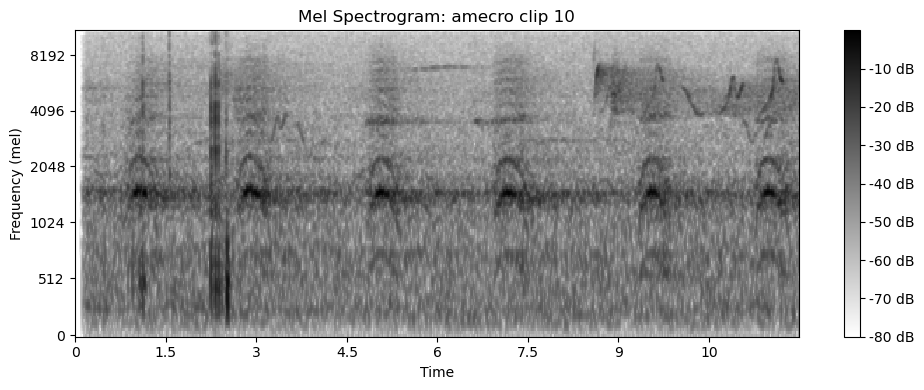

In [5]:
# Example of Spectrogram for American Crow 
plt.figure(figsize=(10, 4))
librosa.display.specshow(f['amecro'][:,:,10], x_axis='time', y_axis='mel', cmap='gray_r')
plt.title('Mel Spectrogram: amecro clip 10')
plt.xlabel('Time')
plt.ylabel('Frequency (mel)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [7]:
# Add name identifier for species
bird_names = {
    "amecro": "American Crow",
    "amerob": "American Robin",
    "bewwre": "Bewick's Wren",
    "bkcchi": "Black-capped Chickadee",
    "daejun": "Dark-eyed Junco",
    "houfin": "House Finch",
    "houspa": "House Sparrow",
    "norfli": "Northern Flicker",
    "rewbla": "Red-winged Blackbird",
    "sonspa": "Song Sparrow",
    "spotow": "Spotted Towhee",
    "whcspa": "White-crowned Sparrow"
}

# Empty dictionary to hold spectrograms.
full_bird = {}

# Generate a dictionary for spectrograms. 
# This will make it easier to prep when doing a binary model.
for name in f.keys():
    # Transpose data from each species to N, 128, 517. 
    full_bird[name] = f[name][:].transpose((2,0,1))
    print(f"{bird_names[name]} ({name}):  {full_bird[name].shape}")
    

American Crow (amecro):  (66, 128, 517)
American Robin (amerob):  (172, 128, 517)
Bewick's Wren (bewwre):  (144, 128, 517)
Black-capped Chickadee (bkcchi):  (45, 128, 517)
Dark-eyed Junco (daejun):  (125, 128, 517)
House Finch (houfin):  (84, 128, 517)
House Sparrow (houspa):  (630, 128, 517)
Northern Flicker (norfli):  (37, 128, 517)
Red-winged Blackbird (rewbla):  (187, 128, 517)
Song Sparrow (sonspa):  (263, 128, 517)
Spotted Towhee (spotow):  (137, 128, 517)
White-crowned Sparrow (whcspa):  (91, 128, 517)


In [9]:
# Accuracy and loss graphs
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper right')
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Loss', 'Validation Loss'], loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def model_matrics(history, title, batch_size):
    print(f'\n{title}')
    
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1] 
    total_epochs = len(history.history['loss'])

    print(f"Epochs Trained: {total_epochs}")
    if batch_size is not None:
        print(f"Batch Size: {batch_size}")
    
    print(f"Final Training Accuracy: {final_train_acc:.3f}")
    print(f"Final Validation Accuracy: {final_val_acc:.3f}")
    print(f"Final Training Loss: {final_train_loss:.3f}")
    print(f"Final Validation Loss: {final_val_loss:.3f}")

In [197]:
# Label Binarizer to transform y values to 0 and 1. 
lb = LabelBinarizer()

# Function to generate data for binary model
def generate_binomial_data(species_list):

    # Empty lists to hold data
    X_list = []
    y_list = []
    
    # Loop through list containing species and append lists
    for species in species_list:
        specs = full_bird[species]
        X_list.append(specs)
        y_list.extend([species] * specs.shape[0])

    # Concatenate a list of spectrograms
    X = np.concatenate(X_list, axis=0)
    y = np.array(y_list)

    # Adding channel dimension
    X = X[..., np.newaxis]

    # Convert categorical labels for species to 0, 1. 
    y = lb.fit_transform(y).ravel()

    # Return prep data for training and testing. 
    # Stratifying on y, since I want equal representation in both training and test sets. 
    return train_test_split(X, y, test_size=0.33, random_state=13, stratify=y)

# Generate data for a binary model 
X_train, X_test, y_train, y_test = generate_binomial_data(['bewwre', 'spotow'])




In [199]:
# Evaluate contents of y_train and y_test
unique, counts = np.unique(y_train, return_counts=True)
print('y_train contents: ')
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")

unique, counts = np.unique(y_test, return_counts=True)
print('\ny_test contents: ')
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")



y_train contents: 
Class 0: 96 samples
Class 1: 92 samples

y_test contents: 
Class 0: 48 samples
Class 1: 45 samples


In [201]:
# Stop training if val_loss does not improve for 3 epochs and returns weights to best val_loss model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model seq_model_simple(title, units, activation function, shape)
def seq_model_simple(title, units, act, shape):
    print(f'{title} (Dense Units: {units}, Activation Function: {act})')
    model = Sequential(
    [
    Dense(units=units, activation=act, input_shape=(shape,)),
    Dense(units=units, activation=act),
    Dense(units=1, activation='sigmoid')
    ])
    return model

# Define model seq_model_simple(title, units, activation function, shape, drop)
def seq_model_simple_drop(title, units, act, shape, drop):
    print(f'{title} (Dense Units: {units}, Activation Function: {act}, Dropout: {drop})')
    model = Sequential([
    Dense(units=units, activation=act, input_shape=(shape,)),
    Dropout(drop),
    Dense(units=units, activation=act),
    Dropout(drop),
    Dense(units=1, activation='sigmoid')])
    return model

# Compile model with seq_model_compile(title, defined model, optimization function, loss function, metric)
def seq_model_compile(title, model, opt, l, m):
    print(f'{title} (Optimizer Function: {opt}, Loss: {l}, Metric: {m})')
    model.compile(optimizer=opt
              , loss= l
              , metrics=[m])
    return model

# Test model simple_model(name, model, X_train, X_test, y_train, y_test, epoch, batch_size, early_stop)
def simple_model(title, model, xtrain, xtest, ytrain, ytest, e, b, stop):
    print(f'{title} (Epoch: {e}, Batch Size: {b})')
    history = model.fit(xtrain, ytrain, 
                    epochs=e, 
                    batch_size=b,
                    validation_data=(xtest, ytest),
                    callbacks=[stop],
                   verbose=0)
    name = f'{title} (Batch Size={b}, Epoch={e})'
    model_matrics(history, name, b)
    loss, acc = model.evaluate(xtest, ytest, verbose=0)
    print(f"Test Accuracy (from model.evaluate): {acc:.3f}")
    print(f"Trainable Params: {model.count_params()}")
    plot_training_history(history, title)
    return history


=== Training Simple MLP with Unit Size: 16 ===

=== Training Simple MLP with Batch Size: 32 ===
Simple MLP (Dense Units: 16, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=32, Epoch=1000)
Epochs Trained: 61
Batch Size: 32
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.505
Final Training Loss: 0.693
Final Validation Loss: 0.694
Test Accuracy (from model.evaluate): 0.505
Trainable Params: 1059121


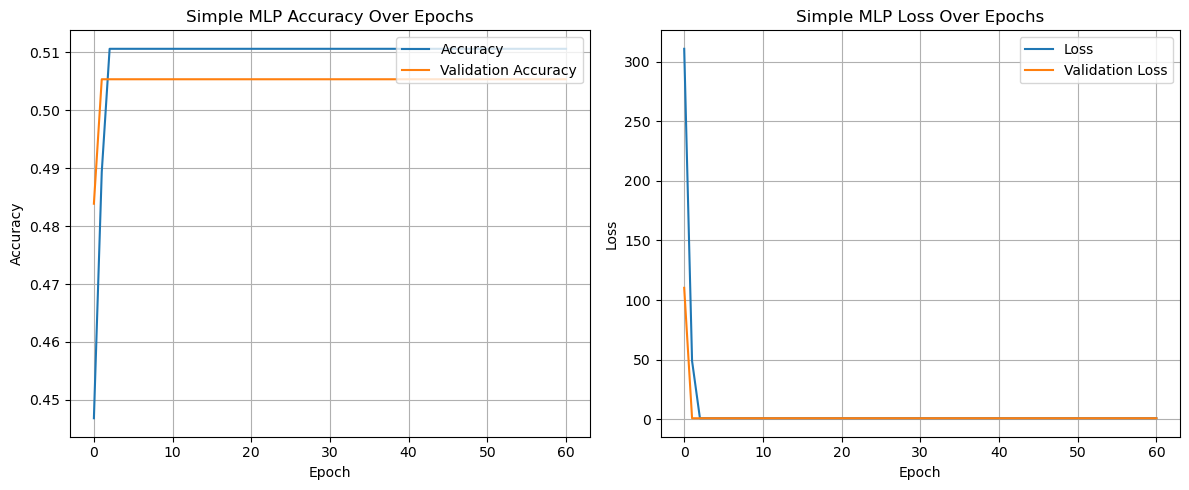

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP with Batch Size: 64 ===
Simple MLP (Dense Units: 16, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=64, Epoch=1000)
Epochs Trained: 11
Batch Size: 64
Final Training Accuracy: 0.479
Final Validation Accuracy: 0.484
Final Training Loss: 23.222
Final Validation Loss: 24.531
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 1059121


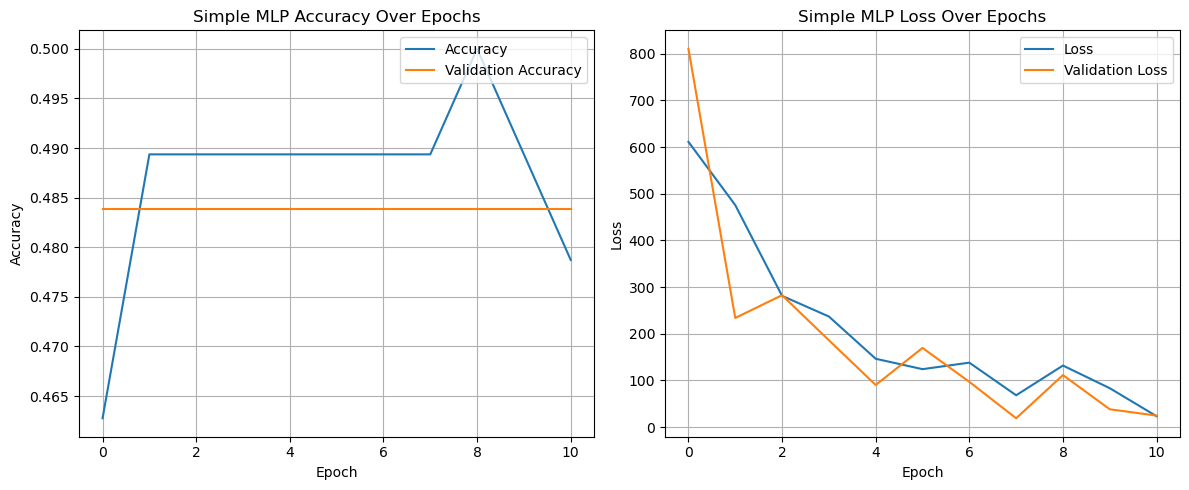

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP with Batch Size: 500 ===
Simple MLP (Dense Units: 16, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=500, Epoch=1000)
Epochs Trained: 146
Batch Size: 500
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.516
Final Training Loss: 0.693
Final Validation Loss: 0.693
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 1059121


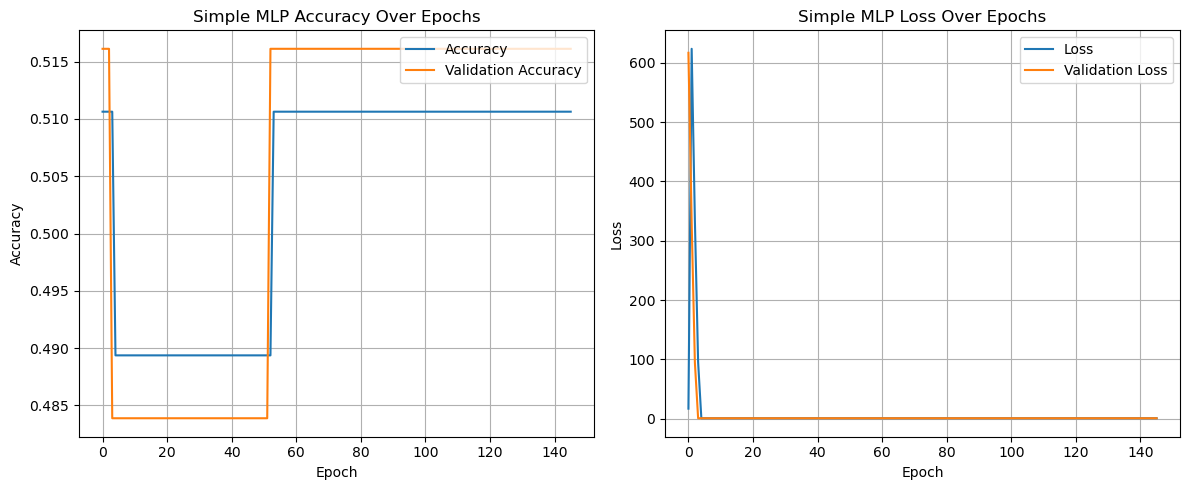

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP with Unit Size: 32 ===

=== Training Simple MLP with Batch Size: 32 ===
Simple MLP (Dense Units: 32, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=32, Epoch=1000)
Epochs Trained: 8
Batch Size: 32
Final Training Accuracy: 0.479
Final Validation Accuracy: 0.516
Final Training Loss: 318.174
Final Validation Loss: 905.095
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 2118753


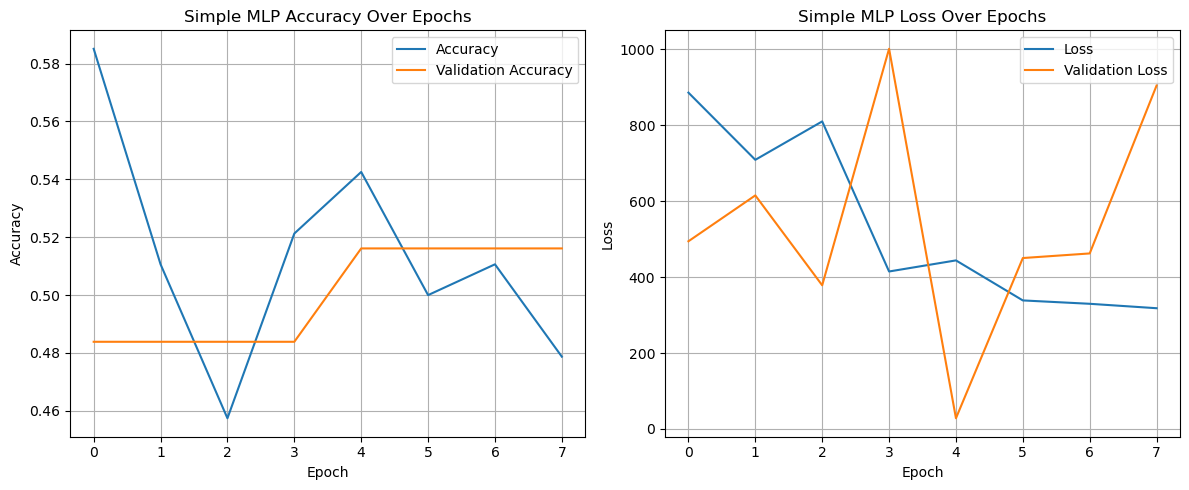

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP with Batch Size: 64 ===
Simple MLP (Dense Units: 32, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=64, Epoch=1000)
Epochs Trained: 6
Batch Size: 64
Final Training Accuracy: 0.457
Final Validation Accuracy: 0.484
Final Training Loss: 698.699
Final Validation Loss: 230.969
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 2118753


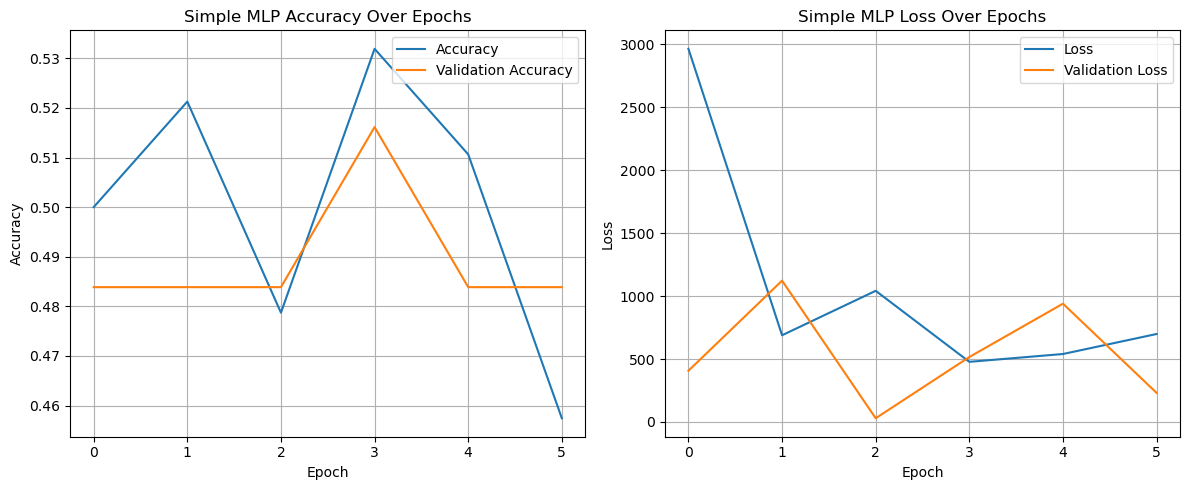

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Training Simple MLP with Batch Size: 500 ===
Simple MLP (Dense Units: 32, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=500, Epoch=1000)
Epochs Trained: 5
Batch Size: 500
Final Training Accuracy: 0.489
Final Validation Accuracy: 0.516
Final Training Loss: 227.642
Final Validation Loss: 1577.145
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 2118753


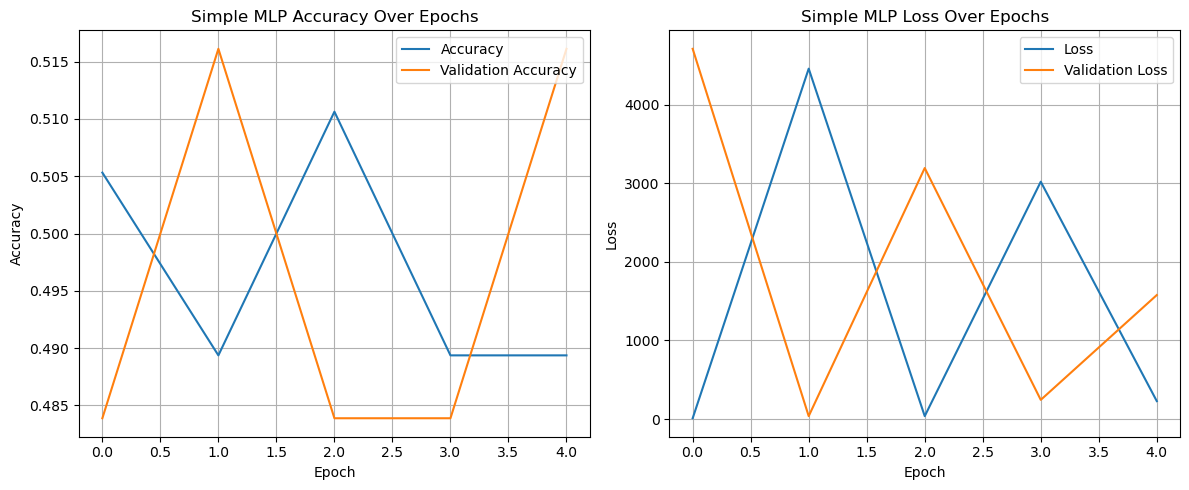

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP with Unit Size: 64 ===

=== Training Simple MLP with Batch Size: 32 ===
Simple MLP (Dense Units: 64, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=32, Epoch=1000)
Epochs Trained: 24
Batch Size: 32
Final Training Accuracy: 0.495
Final Validation Accuracy: 0.516
Final Training Loss: 25.170
Final Validation Loss: 14.566
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 4239553


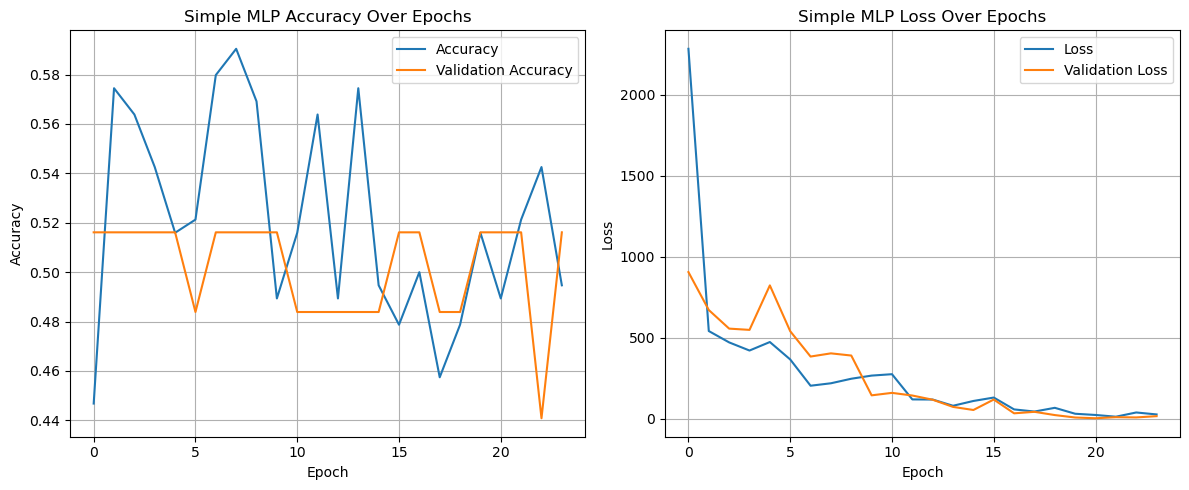

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Training Simple MLP with Batch Size: 64 ===
Simple MLP (Dense Units: 64, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=64, Epoch=1000)
Epochs Trained: 7
Batch Size: 64
Final Training Accuracy: 0.463
Final Validation Accuracy: 0.516
Final Training Loss: 143.879
Final Validation Loss: 311.193
Test Accuracy (from model.evaluate): 0.581
Trainable Params: 4239553


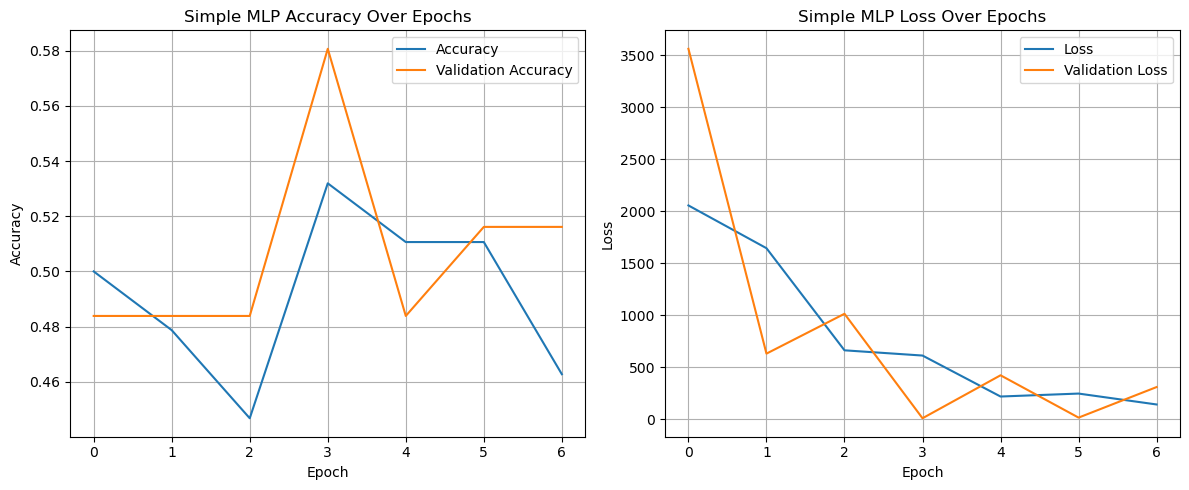

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Training Simple MLP with Batch Size: 500 ===
Simple MLP (Dense Units: 64, Activation Function: relu)
Simple MLP (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Batch Size=500, Epoch=1000)
Epochs Trained: 10
Batch Size: 500
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.484
Final Training Loss: 205.062
Final Validation Loss: 2061.232
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 4239553


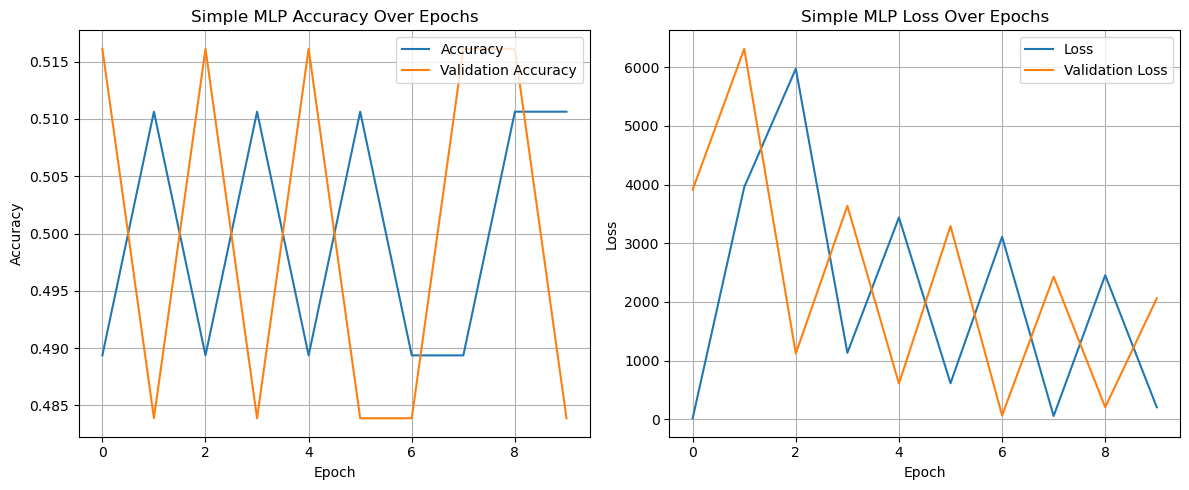

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Units  Batch Size  Epochs Train  TP  TN  FP  FN  Accuracy  Precision  \
0     16          32            61   0  47   1  45  0.505376   0.000000   
1     16          64            11  45   0  48   0  0.483871   0.483871   
2     16         500           146   0  48   0  45  0.516129   0.000000   
3     32          32             8   0  48   0  45  0.516129   0.000000   
4     32          64             6  45   0  48   0  0.483871   0.483871   
5     32         500             5   0  48   0  45  0.516129   0.000000   
6     64          32            24   0  48   0  45  0.516129   0.000000   
7     64          64             7   9  45   3  36  0.580645   0.750000   
8     64         500            10  45   0  48   0  0.483871   0.483871   

   Recall        F1  
0     0.0  0.000000  
1     1.0  0.652174  
2     0.0  0.000000  
3     0.0  0.000000  
4     1.0  0.652174  
5     0.0  0.000000  
6     0.0  0.000000  
7     0.2  0.315789  
8     1.0  0.652174

In [203]:
# MLP model expects a 1D vector, reshaping X_train and X_test
X_train_flat = X_train.reshape(X_train.shape[0] ,-1)
X_test_flat = X_test.reshape(X_test.shape[0] ,-1)

# Params to define model
input_dim = 128 * 517
u = [16, 32, 64]
act = 'relu'

# Params to compile model
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'

# Test model
title = 'Simple MLP'
b_sizes = [32, 64, 500]
epoch = 1000

results = []

# Loop to test different 
for u_size in u:
    print(f"\n=== Training {title} with Unit Size: {u_size} ===")
    for b_size in b_sizes:
        print(f"\n=== Training {title} with Batch Size: {b_size} ===")
        
        model = seq_model_simple(title, u_size, act, input_dim)
        model = seq_model_compile(title, model, opt, l, m)
        
        history = simple_model(title, 
                     model, 
                     X_train_flat, 
                     X_test_flat, 
                     y_train, 
                     y_test, 
                     epoch, 
                     b_size, 
                     stop=early_stop)
       
        y_pred_probs = model.predict(X_test_flat)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results.append({
            'Units': u_size,
            'Batch Size': b_size,
            'Epochs Train': len(history.history['loss']),
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

results_df = pd.DataFrame(results)
display(results_df)


=== Training Simple MLP (Scaled) with Unit Size: 16 ===

=== Training Simple MLP (Scaled) with Batch Size: 32 ===
Simple MLP (Scaled) (Dense Units: 16, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=32, Epoch=1000)
Epochs Trained: 10
Batch Size: 32
Final Training Accuracy: 0.441
Final Validation Accuracy: 0.516
Final Training Loss: 1.665
Final Validation Loss: 1.528
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 1059121


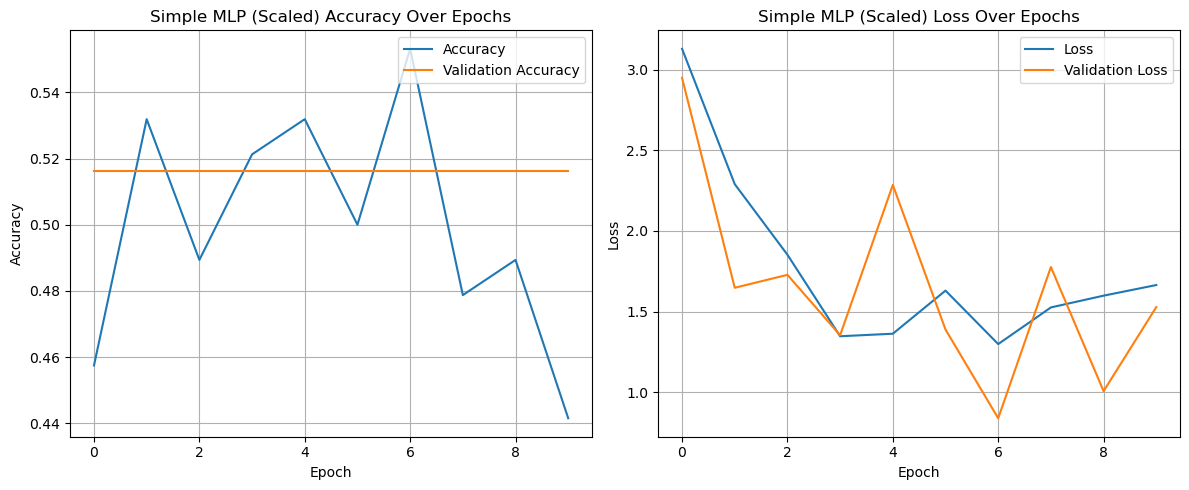

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Scaled) with Batch Size: 64 ===
Simple MLP (Scaled) (Dense Units: 16, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=64, Epoch=1000)
Epochs Trained: 19
Batch Size: 64
Final Training Accuracy: 0.585
Final Validation Accuracy: 0.516
Final Training Loss: 0.687
Final Validation Loss: 0.697
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 1059121


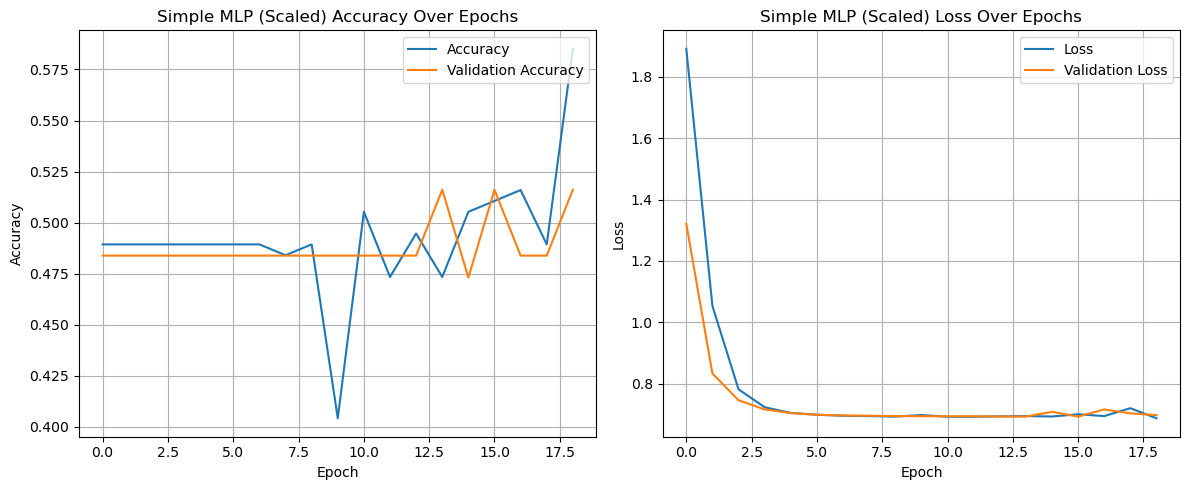

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Scaled) with Batch Size: 500 ===
Simple MLP (Scaled) (Dense Units: 16, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=500, Epoch=1000)
Epochs Trained: 15
Batch Size: 500
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.484
Final Training Loss: 1.861
Final Validation Loss: 5.392
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 1059121


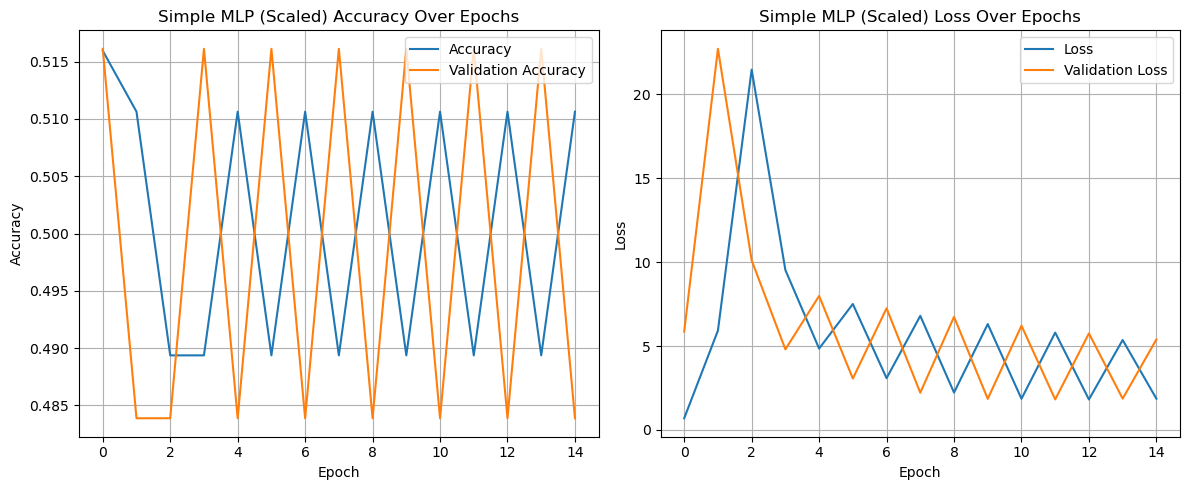

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Scaled) with Unit Size: 32 ===

=== Training Simple MLP (Scaled) with Batch Size: 32 ===
Simple MLP (Scaled) (Dense Units: 32, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=32, Epoch=1000)
Epochs Trained: 5
Batch Size: 32
Final Training Accuracy: 0.457
Final Validation Accuracy: 0.516
Final Training Loss: 1.743
Final Validation Loss: 1.606
Test Accuracy (from model.evaluate): 0.527
Trainable Params: 2118753


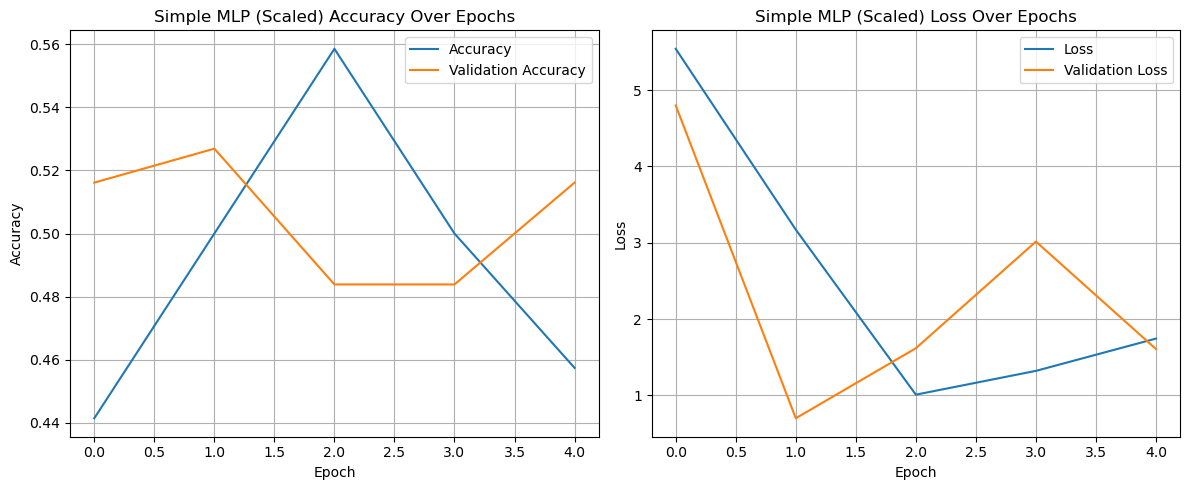

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Scaled) with Batch Size: 64 ===
Simple MLP (Scaled) (Dense Units: 32, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=64, Epoch=1000)
Epochs Trained: 67
Batch Size: 64
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.516
Final Training Loss: 0.693
Final Validation Loss: 0.693
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 2118753


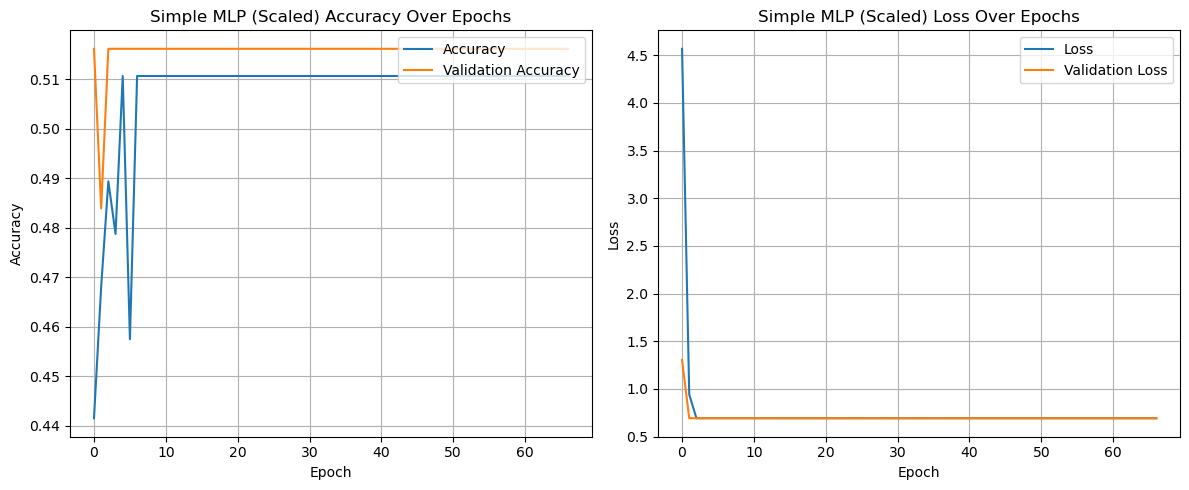

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Training Simple MLP (Scaled) with Batch Size: 500 ===
Simple MLP (Scaled) (Dense Units: 32, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=500, Epoch=1000)
Epochs Trained: 6
Batch Size: 500
Final Training Accuracy: 0.521
Final Validation Accuracy: 0.484
Final Training Loss: 1.705
Final Validation Loss: 15.005
Test Accuracy (from model.evaluate): 0.570
Trainable Params: 2118753


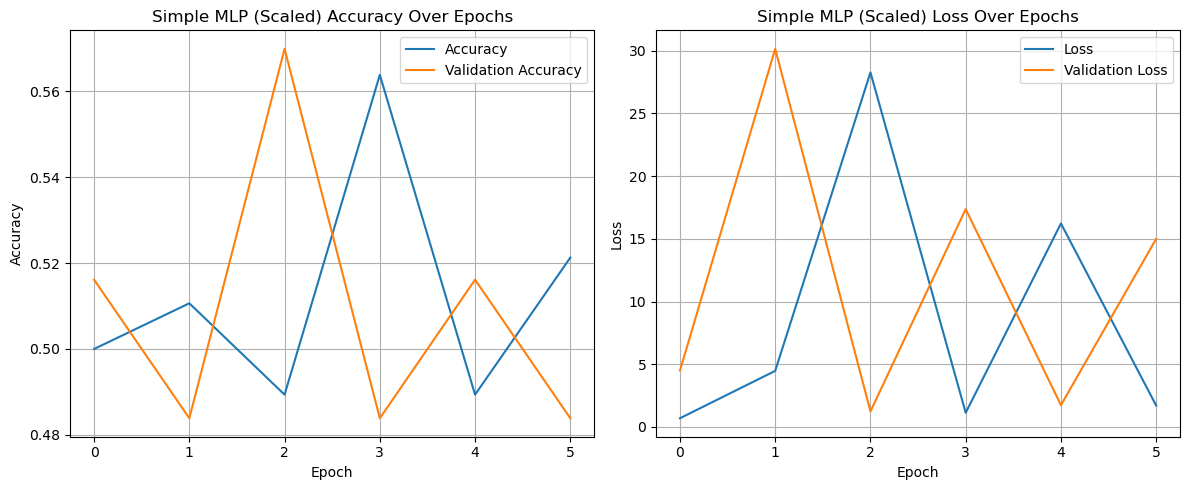

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Scaled) with Unit Size: 64 ===

=== Training Simple MLP (Scaled) with Batch Size: 32 ===
Simple MLP (Scaled) (Dense Units: 64, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=32, Epoch=1000)
Epochs Trained: 5
Batch Size: 32
Final Training Accuracy: 0.543
Final Validation Accuracy: 0.516
Final Training Loss: 1.751
Final Validation Loss: 3.042
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 4239553


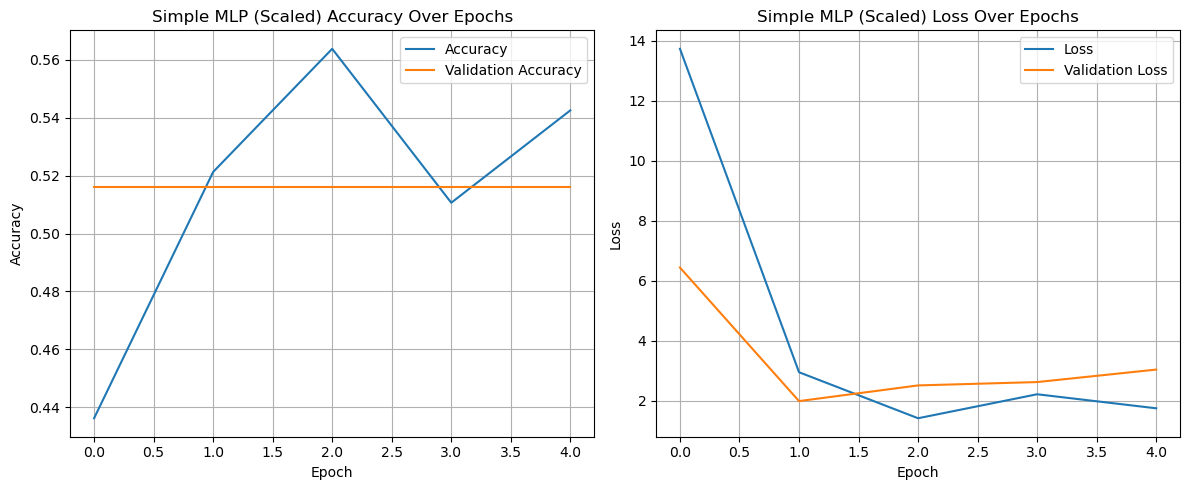

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Scaled) with Batch Size: 64 ===
Simple MLP (Scaled) (Dense Units: 64, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=64, Epoch=1000)
Epochs Trained: 9
Batch Size: 64
Final Training Accuracy: 0.457
Final Validation Accuracy: 0.516
Final Training Loss: 0.972
Final Validation Loss: 1.248
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 4239553


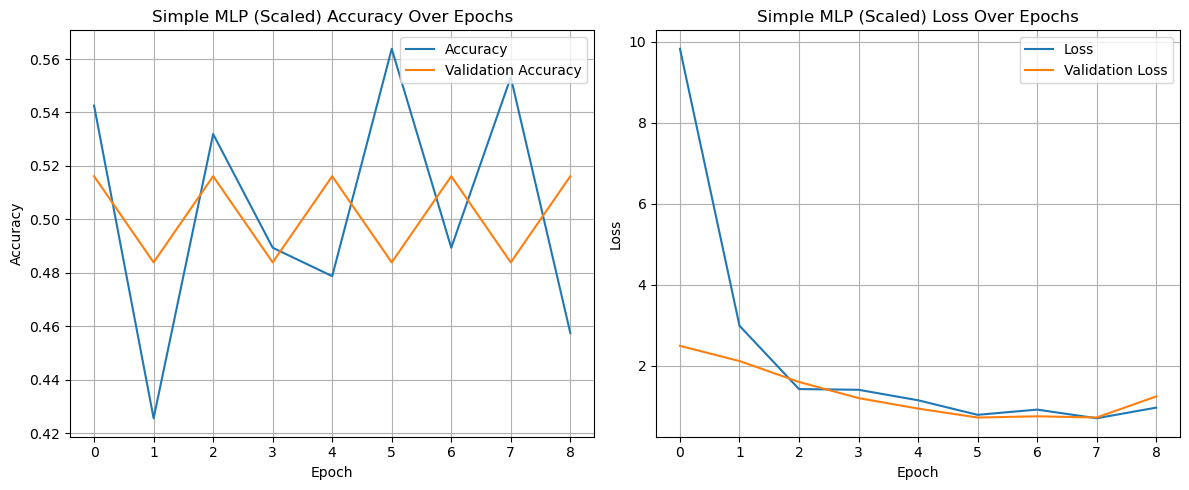

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Training Simple MLP (Scaled) with Batch Size: 500 ===
Simple MLP (Scaled) (Dense Units: 64, Activation Function: relu)
Simple MLP (Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Scaled) (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Scaled) (Batch Size=500, Epoch=1000)
Epochs Trained: 6
Batch Size: 500
Final Training Accuracy: 0.489
Final Validation Accuracy: 0.516
Final Training Loss: 1.729
Final Validation Loss: 1.331
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 4239553


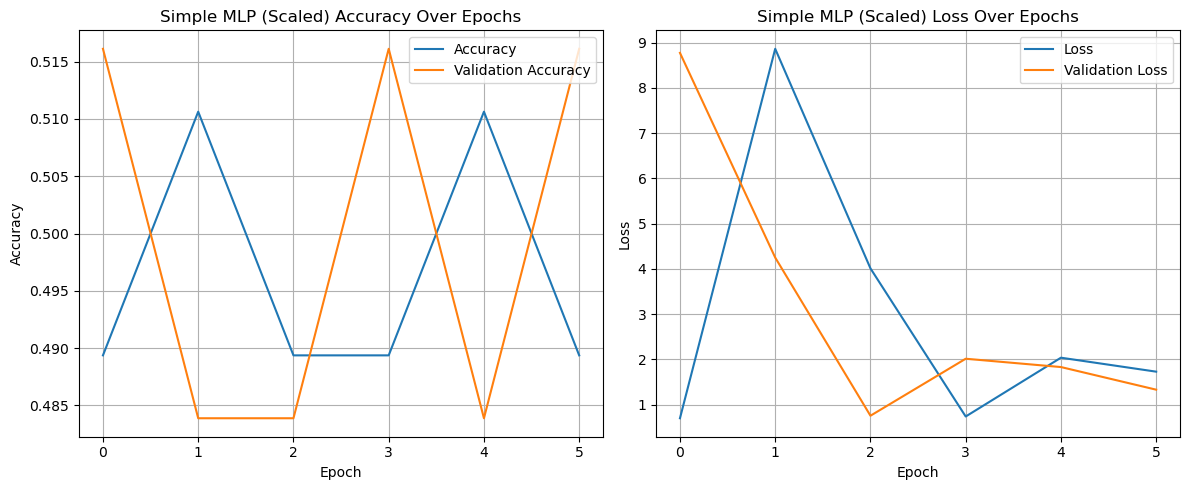

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Units  Batch Size  Epochs Train  TP  TN  FP  FN  Accuracy  Precision  \
0     16          32            10   1  47   1  44  0.516129   0.500000   
1     16          64            19   0  48   0  45  0.516129   0.000000   
2     16         500            15   0  48   0  45  0.516129   0.000000   
3     32          32             5   1  48   0  44  0.526882   1.000000   
4     32          64            67   0  48   0  45  0.516129   0.000000   
5     32         500             6  10  43   5  35  0.569892   0.666667   
6     64          32             5   0  48   0  45  0.516129   0.000000   
7     64          64             9  45   0  48   0  0.483871   0.483871   
8     64         500             6  45   0  48   0  0.483871   0.483871   

     Recall        F1  
0  0.022222  0.042553  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.022222  0.043478  
4  0.000000  0.000000  
5  0.222222  0.333333  
6  0.000000  0.000000  
7  1.000000  0.652174  
8  1.000000  0.652174

In [205]:
# Scaled images to the [0, 1] range
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

# 1D vectors
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# Params to define model
input_dim = 128 * 517
u = [16, 32, 64]
act = 'relu'

# Params to compile model
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'

# Test model
title = 'Simple MLP (Scaled)'
b_sizes = [32, 64, 500]
epoch = 1000

results = []

# Loop to test different 
for u_size in u:
    print(f"\n=== Training {title} with Unit Size: {u_size} ===")
    for b_size in b_sizes:
        print(f"\n=== Training {title} with Batch Size: {b_size} ===")
        
        model = seq_model_simple(title, u_size, act, input_dim)
        model = seq_model_compile(title, model, opt, l, m)
        
        history = simple_model(title, 
                     model, 
                     X_train_flat, 
                     X_test_flat, 
                     y_train, 
                     y_test, 
                     epoch, 
                     b_size, 
                     stop=early_stop)
       
        y_pred_probs = model.predict(X_test_flat)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results.append({
            'Units': u_size,
            'Batch Size': b_size,
            'Epochs Train': len(history.history['loss']),
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

results_df = pd.DataFrame(results)
display(results_df)


=== Training Simple MLP (Z Scaled) with Unit Size: 16 ===

=== Training Simple MLP (Z Scaled) with Batch Size: 32 ===
Simple MLP (Z Scaled) (Dense Units: 16, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=32, Epoch=1000)
Epochs Trained: 11
Batch Size: 32
Final Training Accuracy: 0.516
Final Validation Accuracy: 0.516
Final Training Loss: 406.022
Final Validation Loss: 766.301
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 1059121


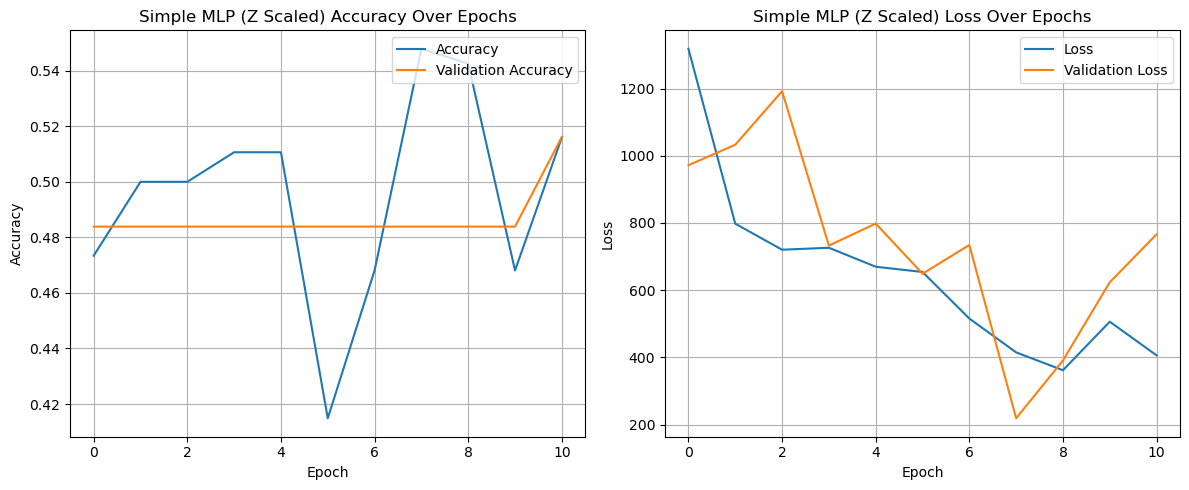

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Z Scaled) with Batch Size: 64 ===
Simple MLP (Z Scaled) (Dense Units: 16, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=64, Epoch=1000)
Epochs Trained: 6
Batch Size: 64
Final Training Accuracy: 0.489
Final Validation Accuracy: 0.516
Final Training Loss: 8.166
Final Validation Loss: 7.217
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 1059121


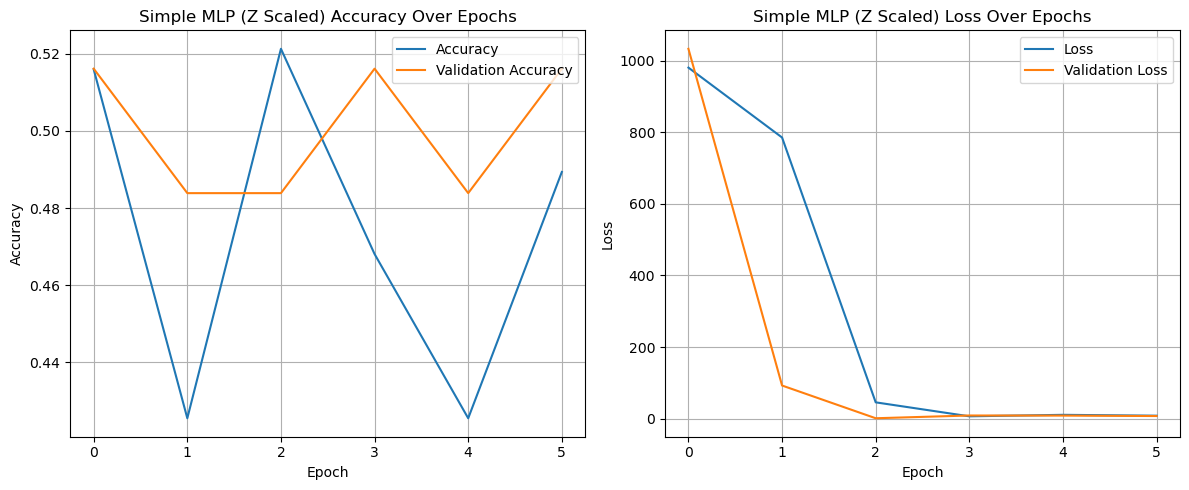

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Z Scaled) with Batch Size: 500 ===
Simple MLP (Z Scaled) (Dense Units: 16, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=500, Epoch=1000)
Epochs Trained: 9
Batch Size: 500
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.484
Final Training Loss: 148.349
Final Validation Loss: 378.533
Test Accuracy (from model.evaluate): 0.462
Trainable Params: 1059121


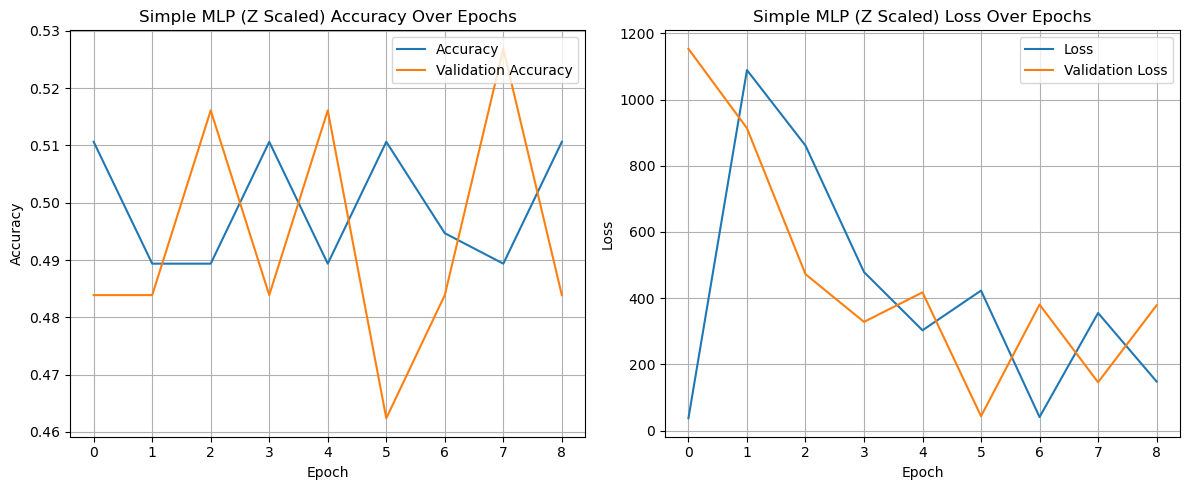

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Training Simple MLP (Z Scaled) with Unit Size: 32 ===

=== Training Simple MLP (Z Scaled) with Batch Size: 32 ===
Simple MLP (Z Scaled) (Dense Units: 32, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=32, Epoch=1000)
Epochs Trained: 8
Batch Size: 32
Final Training Accuracy: 0.489
Final Validation Accuracy: 0.484
Final Training Loss: 46.705
Final Validation Loss: 46.867
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 2118753


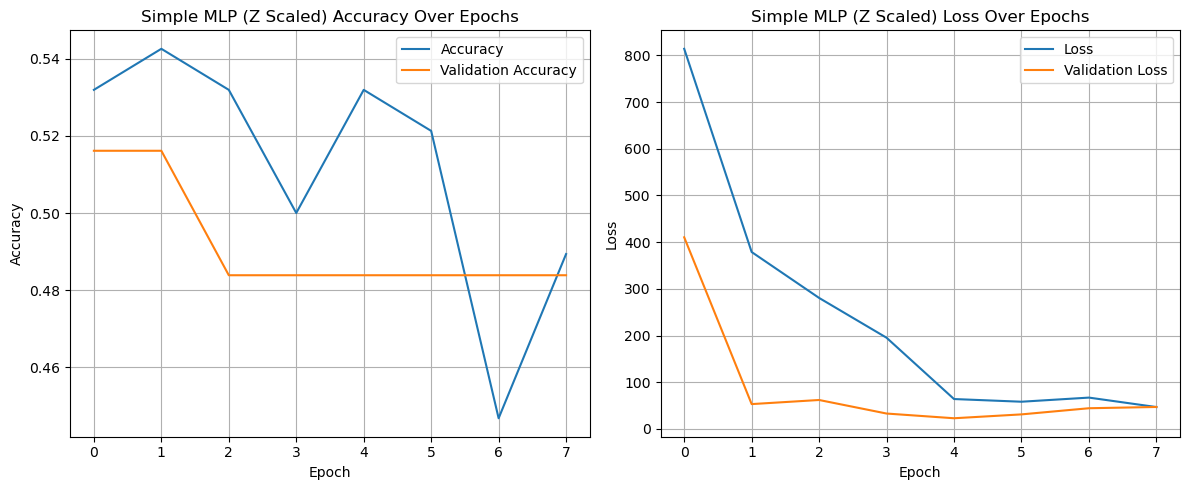

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Z Scaled) with Batch Size: 64 ===
Simple MLP (Z Scaled) (Dense Units: 32, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=64, Epoch=1000)
Epochs Trained: 8
Batch Size: 64
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.516
Final Training Loss: 363.927
Final Validation Loss: 73.287
Test Accuracy (from model.evaluate): 0.430
Trainable Params: 2118753


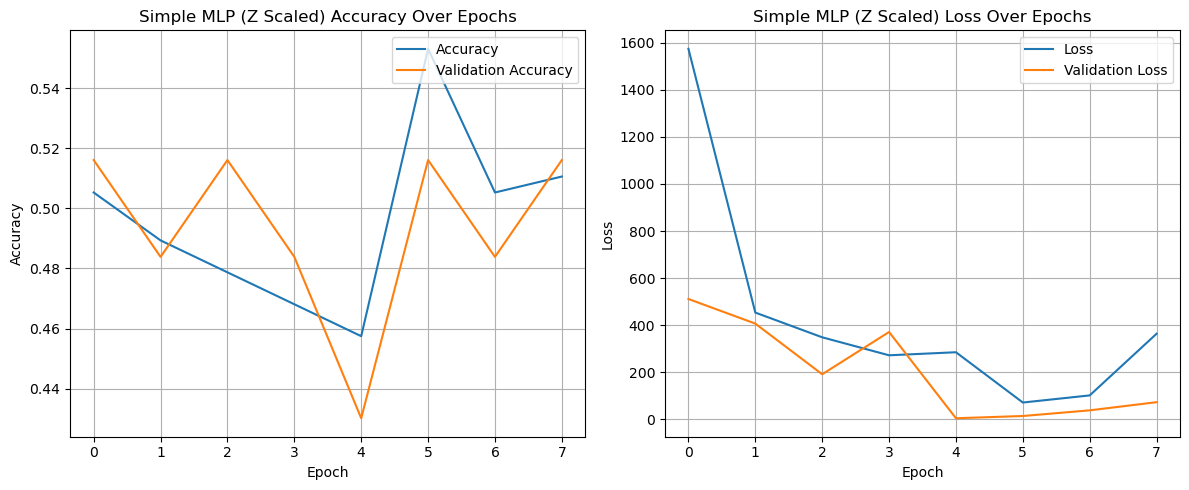

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Z Scaled) with Batch Size: 500 ===
Simple MLP (Z Scaled) (Dense Units: 32, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=500, Epoch=1000)
Epochs Trained: 7
Batch Size: 500
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.484
Final Training Loss: 191.046
Final Validation Loss: 471.429
Test Accuracy (from model.evaluate): 0.484
Trainable Params: 2118753


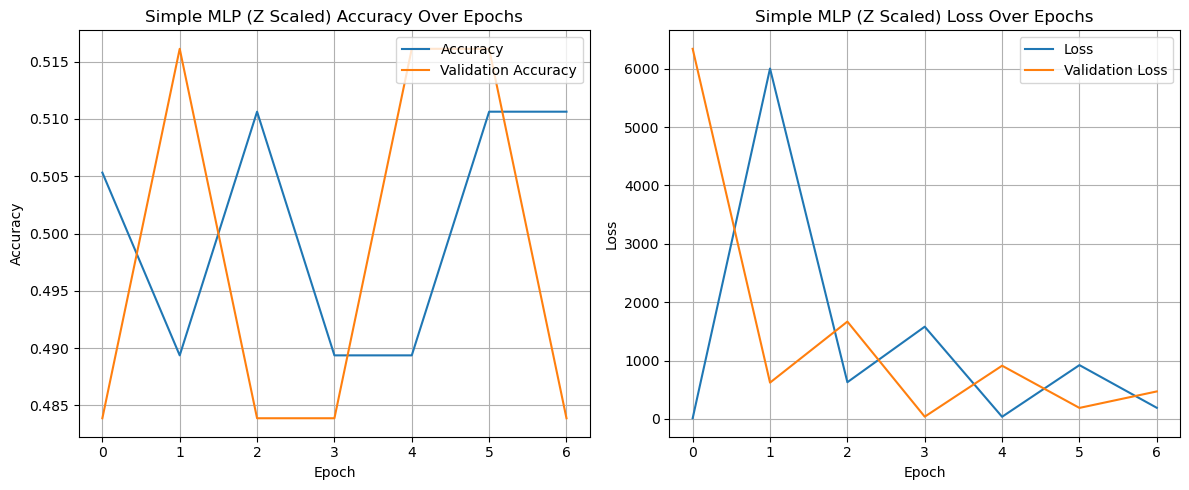

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

=== Training Simple MLP (Z Scaled) with Unit Size: 64 ===

=== Training Simple MLP (Z Scaled) with Batch Size: 32 ===
Simple MLP (Z Scaled) (Dense Units: 64, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=32, Epoch=1000)
Epochs Trained: 62
Batch Size: 32
Final Training Accuracy: 0.511
Final Validation Accuracy: 0.516
Final Training Loss: 0.693
Final Validation Loss: 0.693
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 4239553


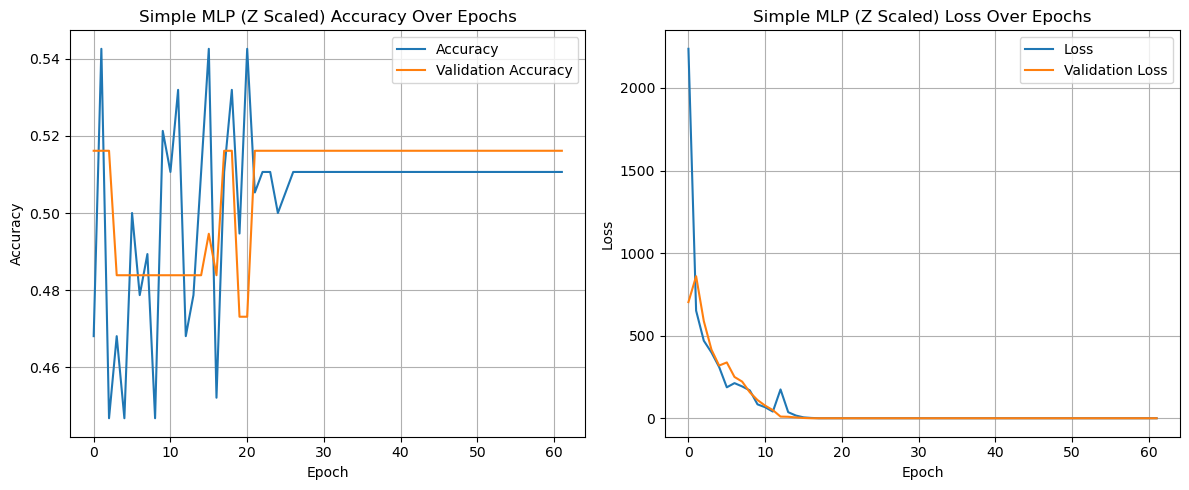

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Training Simple MLP (Z Scaled) with Batch Size: 64 ===
Simple MLP (Z Scaled) (Dense Units: 64, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 64)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=64, Epoch=1000)
Epochs Trained: 14
Batch Size: 64
Final Training Accuracy: 0.532
Final Validation Accuracy: 0.484
Final Training Loss: 206.358
Final Validation Loss: 167.539
Test Accuracy (from model.evaluate): 0.495
Trainable Params: 4239553


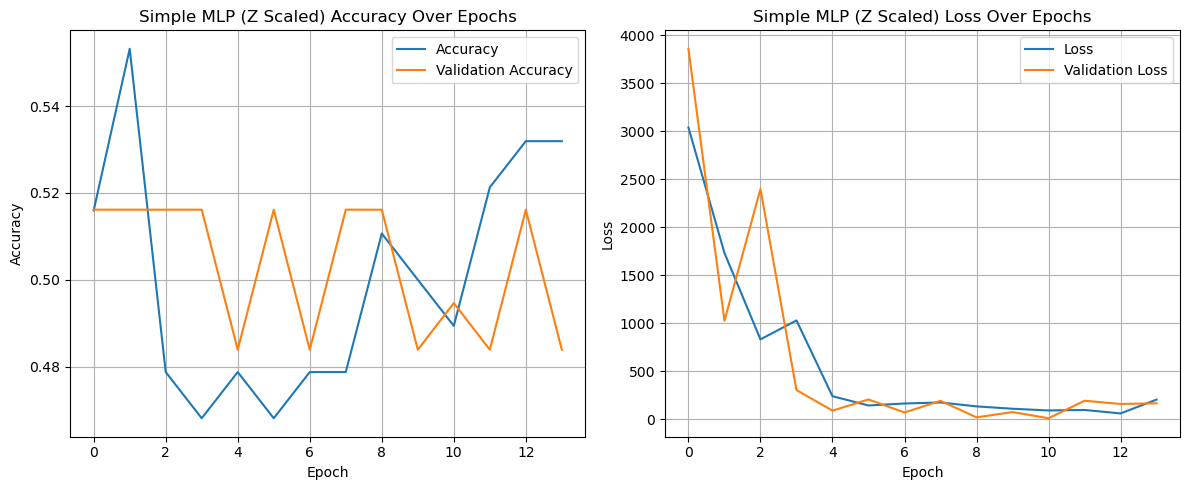

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Training Simple MLP (Z Scaled) with Batch Size: 500 ===
Simple MLP (Z Scaled) (Dense Units: 64, Activation Function: relu)
Simple MLP (Z Scaled) (Optimizer Function: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
Simple MLP (Z Scaled) (Epoch: 1000, Batch Size: 500)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple MLP (Z Scaled) (Batch Size=500, Epoch=1000)
Epochs Trained: 5
Batch Size: 500
Final Training Accuracy: 0.489
Final Validation Accuracy: 0.516
Final Training Loss: 422.180
Final Validation Loss: 1211.839
Test Accuracy (from model.evaluate): 0.516
Trainable Params: 4239553


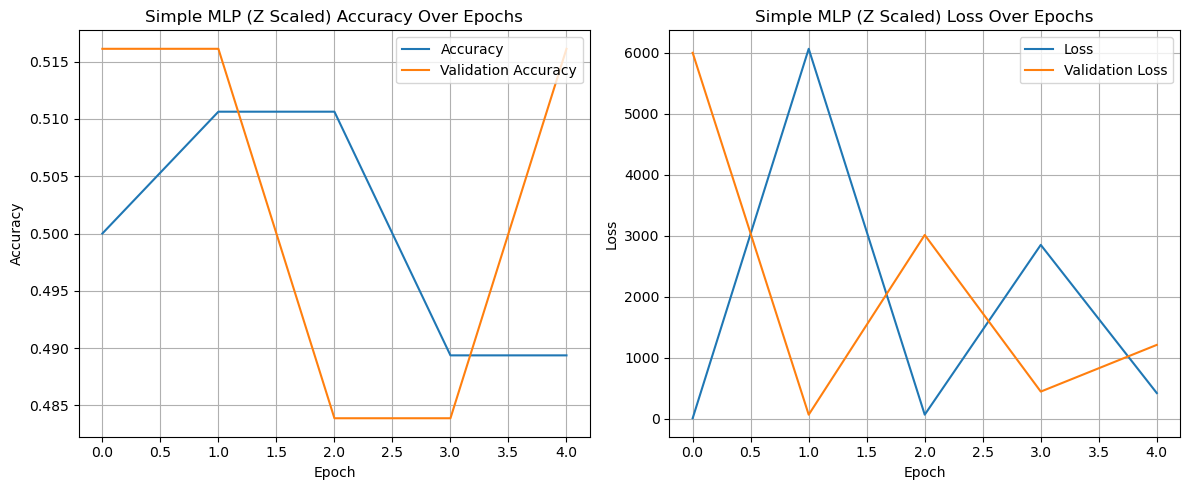

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Units  Batch Size  Epochs Train  TP  TN  FP  FN  Accuracy  Precision  \
0     16          32            11  45   0  48   0  0.483871   0.483871   
1     16          64             6  45   0  48   0  0.483871   0.483871   
2     16         500             9  11  32  16  34  0.462366   0.407407   
3     32          32             8  45   0  48   0  0.483871   0.483871   
4     32          64             8  26  14  34  19  0.430108   0.433333   
5     32         500             7  45   0  48   0  0.483871   0.483871   
6     64          32            62   0  48   0  45  0.516129   0.000000   
7     64          64            14  45   1  47   0  0.494624   0.489130   
8     64         500             5   0  48   0  45  0.516129   0.000000   

     Recall        F1  
0  1.000000  0.652174  
1  1.000000  0.652174  
2  0.244444  0.305556  
3  1.000000  0.652174  
4  0.577778  0.495238  
5  1.000000  0.652174  
6  0.000000  0.000000  
7  1.000000  0.656934  
8  0.000000  0.000000

In [207]:
# 1D vectors
X_train_flat = X_train.reshape(X_train.shape[0] ,-1)
X_test_flat = X_test.reshape(X_test.shape[0] ,-1)

mean = np.mean(X_train_flat)
std = np.std(X_train_flat)

X_train_flat_scaled = (X_train_flat - mean) / std
X_test_flat_scaled = (X_test_flat - mean) / std


# Params to define model
input_dim = 128 * 517
u = [16, 32, 64]
act = 'relu'

# Params to compile model
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'

# Test model
title = 'Simple MLP (Z Scaled)'
b_sizes = [32, 64, 500]
epoch = 1000

results = []

# Loop to test different 
for u_size in u:
    print(f"\n=== Training {title} with Unit Size: {u_size} ===")
    for b_size in b_sizes:
        print(f"\n=== Training {title} with Batch Size: {b_size} ===")
        
        model = seq_model_simple(title, u_size, act, input_dim)
        model = seq_model_compile(title, model, opt, l, m)
        
        history = simple_model(title, 
                     model, 
                     X_train_flat, 
                     X_test_flat, 
                     y_train, 
                     y_test, 
                     epoch, 
                     b_size, 
                     stop=early_stop)
       
        y_pred_probs = model.predict(X_test_flat)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results.append({
            'Units': u_size,
            'Batch Size': b_size,
            'Epochs Train': len(history.history['loss']),
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

results_df = pd.DataFrame(results)
display(results_df)

In [82]:
# Build CNN model
def build_cnn_model(name, layers, channels, k_size, pool, act, drop, dense, u):
    print(f'{name} with {layers} layer(s), {channels} channels, {k_size} kernel size, {pool} pool size, {act} activation, {drop} dropout, {dense} hidden dense layer(s)')
    
    model = Sequential()
    model.add(Input(shape=(128, 517, 1)))
    model.add(Conv2D(filters=channels, kernel_size=k_size, padding='same', activation=act))
    model.add(MaxPooling2D(pool_size=pool))

    for i in range(1, layers):
        model.add(Conv2D(filters=channels * (2**i), kernel_size=k_size, padding='same', activation=act))
        model.add(MaxPooling2D(pool_size=pool))

    model.add(Flatten())
    model.add(Dropout(drop))
    
    units = u
    for j in range(dense):
        units = int(units)
        model.add(Dense(units=units, activation=act))
        if drop > 0:
            model.add(Dropout(drop)) 
        units = units/2

    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile function
def seq_model_compile(title, model, opt, l, m):
    print(f'{title} Compiled (Optimizer: {opt}, Loss: {l}, Metric: {m})')
    model.compile(optimizer=opt, loss=l, metrics=[m])
    return model

# Train and evaluate
def cnn_model(title, model, xtrain, xtest, ytrain, ytest, e, b, stop):
    print(f'{title} Tested (Optimizer: {opt}, Loss: {l}, Metric: {m})')
    history = model.fit(xtrain, ytrain, 
                        epochs=e, 
                        batch_size=b,
                        validation_data=(xtest, ytest),
                        callbacks=[stop],
                        verbose=0)
    name = f'{title} (Batch Size={b}, Epoch={e})'
    model_matrics(history, name, b)
    loss, acc = model.evaluate(xtest, ytest, verbose=0)
    print(f"Test Accuracy: {acc:.3f}")
    print(f"Trainable Params: {model.count_params()}")
    plot_training_history(history, title)
    return history

def cnn_metrics(model, y_test, X_test_scaled, layers, channels, lb):
    y_pred_probs = model.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    label_map = f"{lb.classes_[0]}=0, {lb.classes_[1]}=1"

    results_df = pd.DataFrame([{
        'Label Mapping': label_map,
        'Layers': layers,
        'Channels': channels,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }])
    
    display(results_df)

CNN Scaled Data with 1 layer(s), 16 channels, (3, 3) kernel size, (2, 2) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 12
Batch Size: 32
Final Training Accuracy: 0.697
Final Validation Accuracy: 0.516
Final Training Loss: 0.570
Final Validation Loss: 0.822
Test Accuracy: 0.602
Trainable Params: 264353


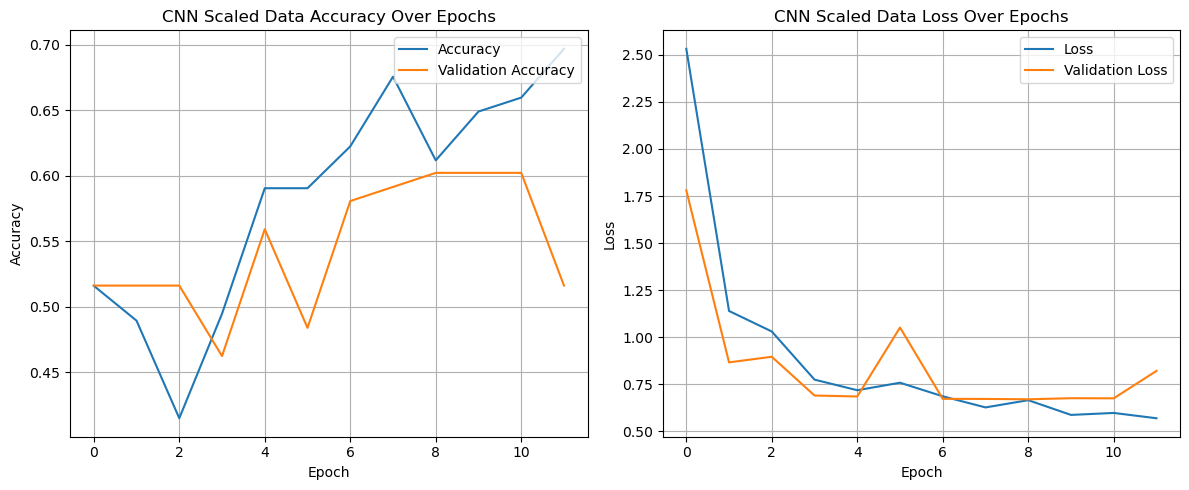

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Scaled Data       1        16  (3, 3)  (2, 2)      0.5             0   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          128          32              12            264353  22  34  14  23   

   Accuracy  Precision    Recall       F1  
0  0.602151   0.611111  0.488889  0.54321

In [39]:
# Generate data for a binary model
X_train, X_test, y_train, y_test = generate_binomial_data(['bewwre', 'spotow'])
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

# Params
layer_list = [1]
channels = 16
k_size = (3, 3)
pool = (2, 2)
act = 'relu'
dropout = 0.5
dense_layers = 0
units = 128
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Scaled Data'
batch = 32
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for layers in layer_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)


In [43]:
mean = np.mean(X_train)
std = np.std(X_train)

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

CNN Z-Scaled Data with 1 layer(s), 16 channels, (3, 3) kernel size, (2, 2) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 18
Batch Size: 32
Final Training Accuracy: 0.676
Final Validation Accuracy: 0.559
Final Training Loss: 1.025
Final Validation Loss: 0.838
Test Accuracy: 0.645
Trainable Params: 264353


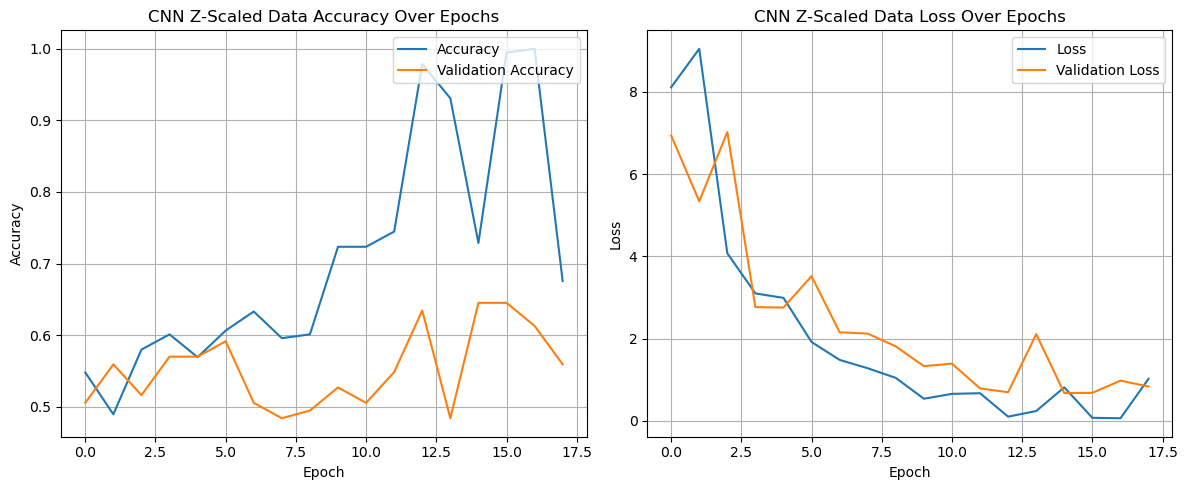

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       1        16  (3, 3)  (2, 2)      0.5             0   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          128          32              18            264353  28  32  16  17   

   Accuracy  Precision    Recall        F1  
0  0.645161   0.636364  0.622222  0.629213

In [45]:
# Params
layer_list = [1]
channels = 16
k_size = (3, 3)
pool = (2, 2)
act = 'relu'
dropout = 0.5
dense_layers = 0
units = 128
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 32
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for layers in layer_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

### Observation: 
Z-scaling the data improved result (Accuracy, Precision, Recall, F1 Score). All model tuning will be done with Z-scaled data

# CNN Hyperparameter Optimization

### Layer Optimization

CNN Z-Scaled Data with 1 layer(s), 16 channels, (3, 3) kernel size, (2, 2) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 8
Batch Size: 32
Final Training Accuracy: 0.686
Final Validation Accuracy: 0.484
Final Training Loss: 1.313
Final Validation Loss: 4.232
Test Accuracy: 0.581
Trainable Params: 264353


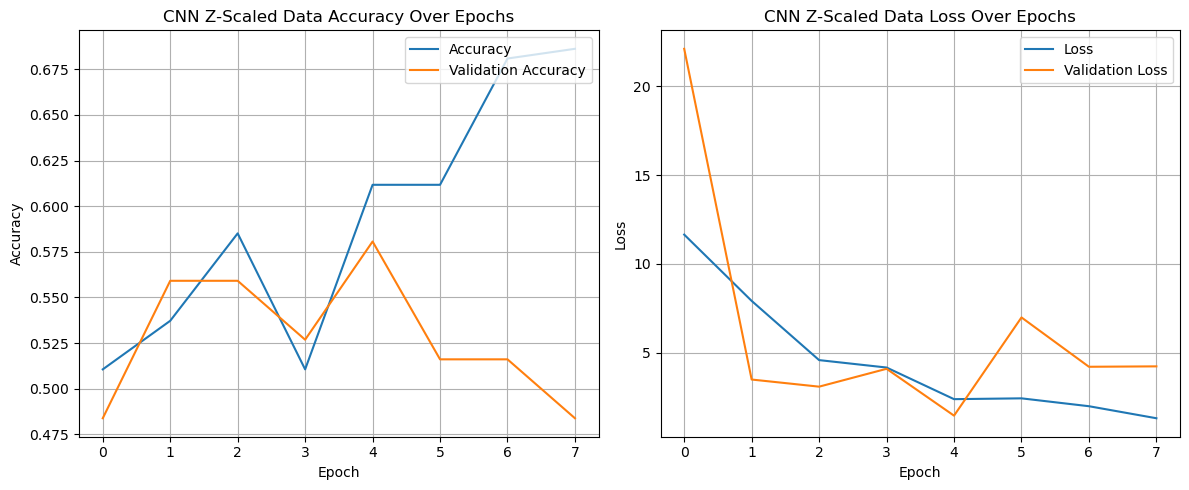

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
CNN Z-Scaled Data with 2 layer(s), 16 channels, (3, 3) kernel size, (2, 2) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 12
Batch Size: 32
Final Training Accuracy: 0.936
Final Validation Accuracy: 0.570
Final Training Loss: 0.231
Final Validation Loss: 0.675
Test Accuracy: 0.634
Trainable Params: 136897


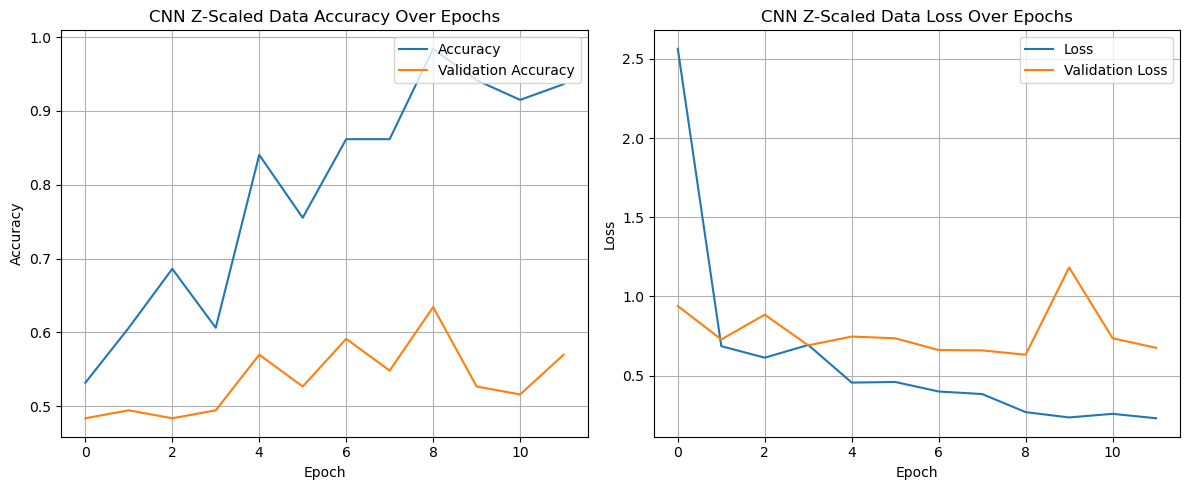

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (2, 2) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 15
Batch Size: 32
Final Training Accuracy: 0.851
Final Validation Accuracy: 0.613
Final Training Loss: 0.330
Final Validation Loss: 0.818
Test Accuracy: 0.645
Trainable Params: 88833


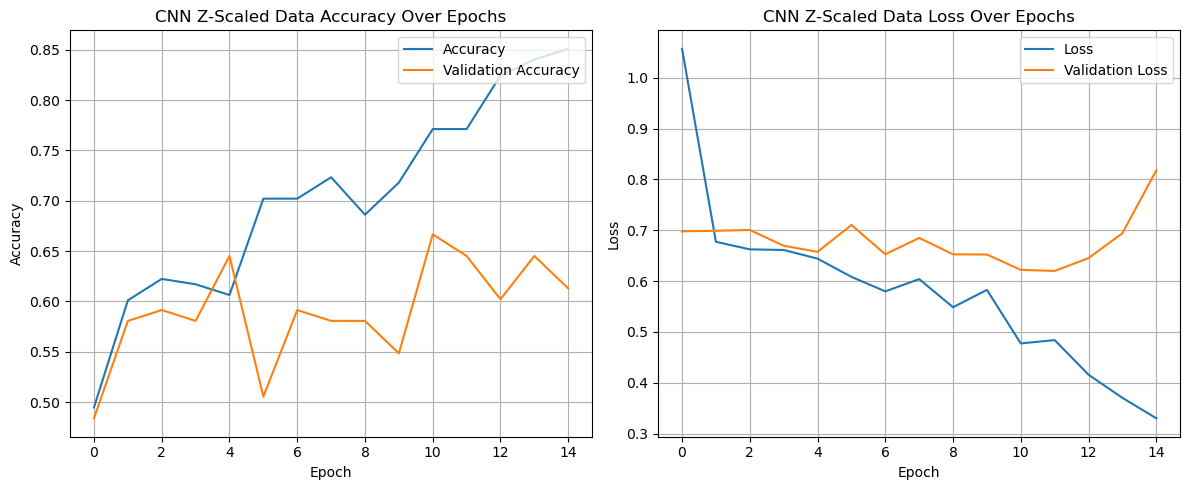

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       1        16  (3, 3)  (2, 2)      0.5             0   
1  CNN Z-Scaled Data       2        16  (3, 3)  (2, 2)      0.5             0   
2  CNN Z-Scaled Data       3        16  (3, 3)  (2, 2)      0.5             0   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          128          32               8            264353  26  28  20  19   
1          128          32              12            136897  25  34  14  20   
2          128          32              15             88833  19  41   7  26   

   Accuracy  Precision    Recall        F1  
0  0.580645   0.565217  0.577778  0.571429  
1  0.634409   0.641026  0.555556  0.595238  
2  0.645161   0.730769  0.422222  0.535211

In [50]:
layer_list = [1, 2, 3]
channels = 16
k_size = (3, 3)
pool = (2, 2)
act = 'relu'
dropout = 0.5
dense_layers = 0
units = 128
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 32
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for layers in layer_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: 3 layers gave us good accuracy and Precision, but lower F1 scores. We will proceed with three layers for now

### Pool Optimization

CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (2, 2) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 14
Batch Size: 32
Final Training Accuracy: 0.915
Final Validation Accuracy: 0.527
Final Training Loss: 0.316
Final Validation Loss: 1.285
Test Accuracy: 0.624
Trainable Params: 88833


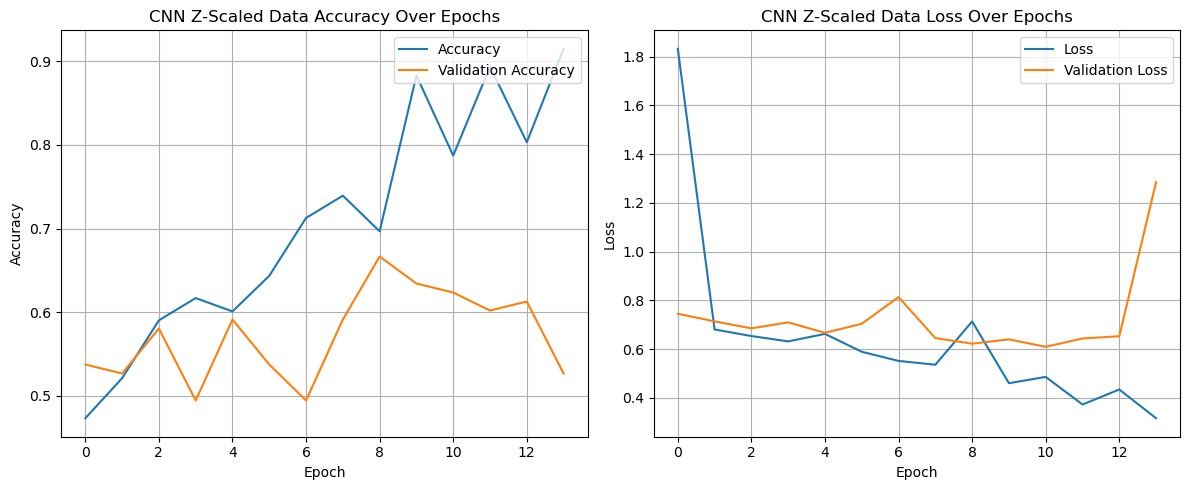

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 7
Batch Size: 32
Final Training Accuracy: 0.739
Final Validation Accuracy: 0.667
Final Training Loss: 0.566
Final Validation Loss: 0.614
Test Accuracy: 0.720
Trainable Params: 28161


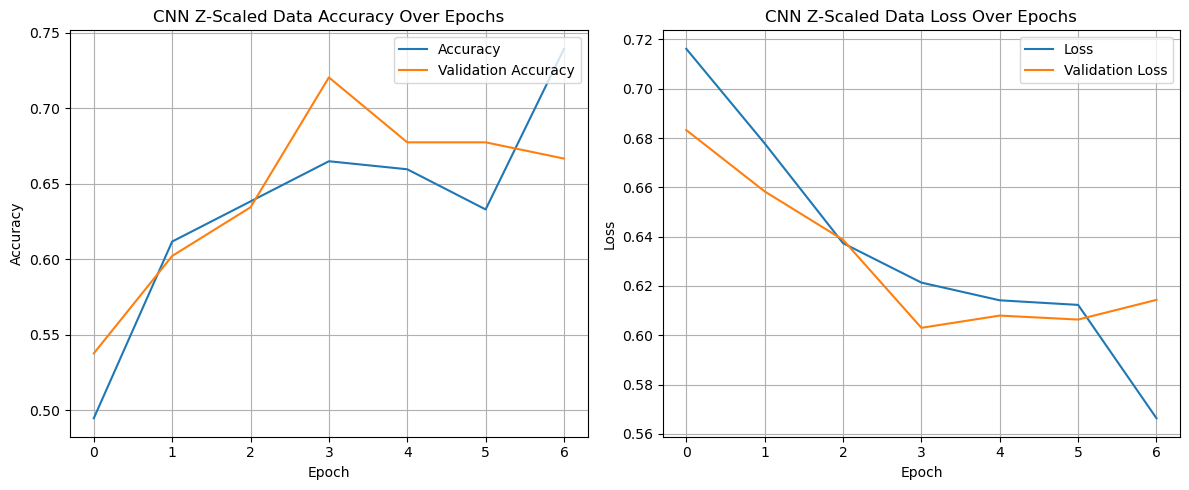

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (4, 4) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 13
Batch Size: 32
Final Training Accuracy: 0.739
Final Validation Accuracy: 0.656
Final Training Loss: 0.557
Final Validation Loss: 0.619
Test Accuracy: 0.688
Trainable Params: 24321


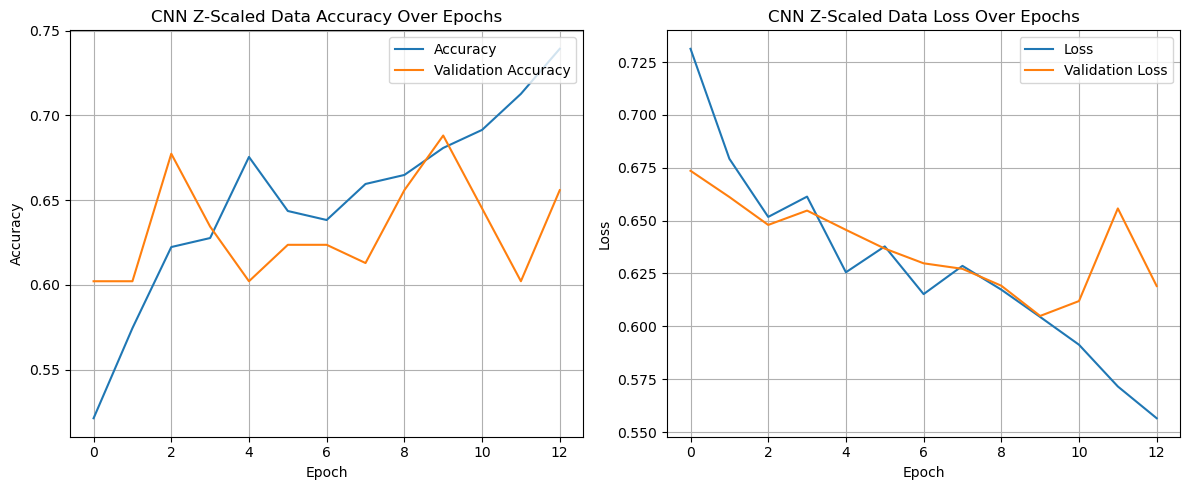

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (5, 5) pool size, relu activation, 0.5 dropout, 0 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 14
Batch Size: 32
Final Training Accuracy: 0.649
Final Validation Accuracy: 0.591
Final Training Loss: 0.609
Final Validation Loss: 0.688
Test Accuracy: 0.613
Trainable Params: 23553


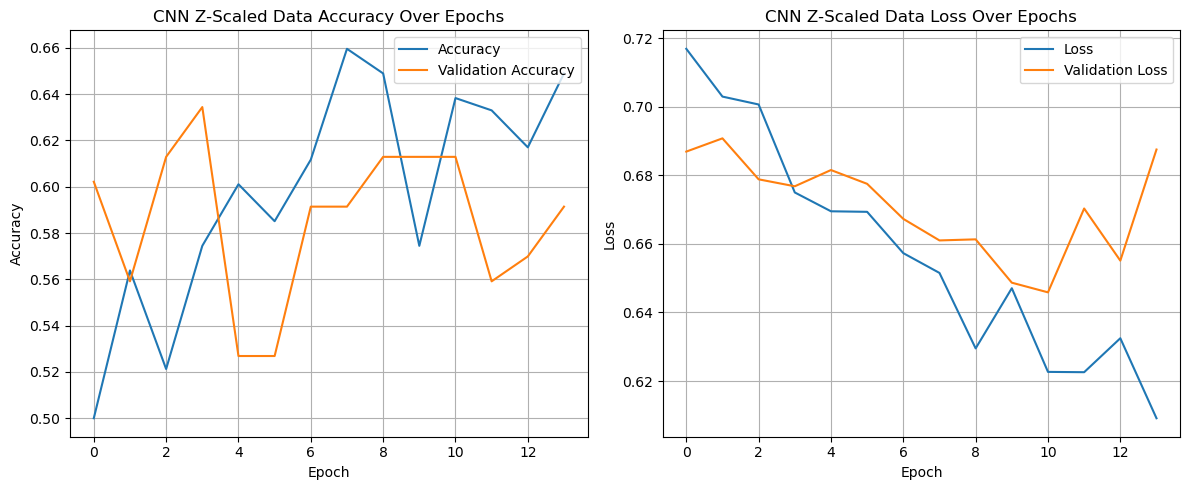

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (3, 3)  (2, 2)      0.5             0   
1  CNN Z-Scaled Data       3        16  (3, 3)  (3, 3)      0.5             0   
2  CNN Z-Scaled Data       3        16  (3, 3)  (4, 4)      0.5             0   
3  CNN Z-Scaled Data       3        16  (3, 3)  (5, 5)      0.5             0   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          128          32              14             88833  27  31  17  18   
1          128          32               7             28161  29  38  10  16   
2          128          32              13             24321  25  39   9  20   
3          128          32              14             23553  17  40   8  28   

   Accuracy  Precision    Recall        F1  
0  0.623656   0.613636  0.600000  0.606742  
1  0.720430   0.743590  0.644444  0.690476  
2  0.688172   0.735294  0.555556  0.632911  
3  0.612903   0.680000  0.377778  0.485714

In [59]:
layers = 3
channels = 16
k_size = (3, 3)
pool_list = [(2, 2), (3,3), (4,4), (5,5)]
act = 'relu'
dropout = 0.5
dense_layers = 0
units = 128
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 32
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for pool in pool_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: Higher performance of pool size (3,3)

### Dense layer Units Optmization

CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 14
Batch Size: 32
Final Training Accuracy: 0.803
Final Validation Accuracy: 0.538
Final Training Loss: 0.454
Final Validation Loss: 0.810
Test Accuracy: 0.645
Trainable Params: 2514689


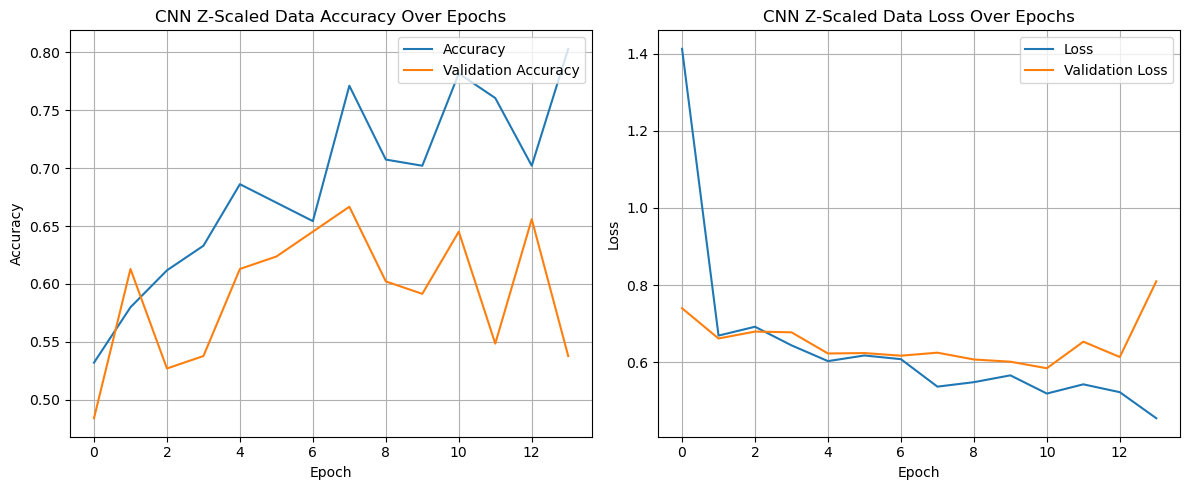

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 15
Batch Size: 32
Final Training Accuracy: 0.755
Final Validation Accuracy: 0.591
Final Training Loss: 0.497
Final Validation Loss: 0.641
Test Accuracy: 0.699
Trainable Params: 1268993


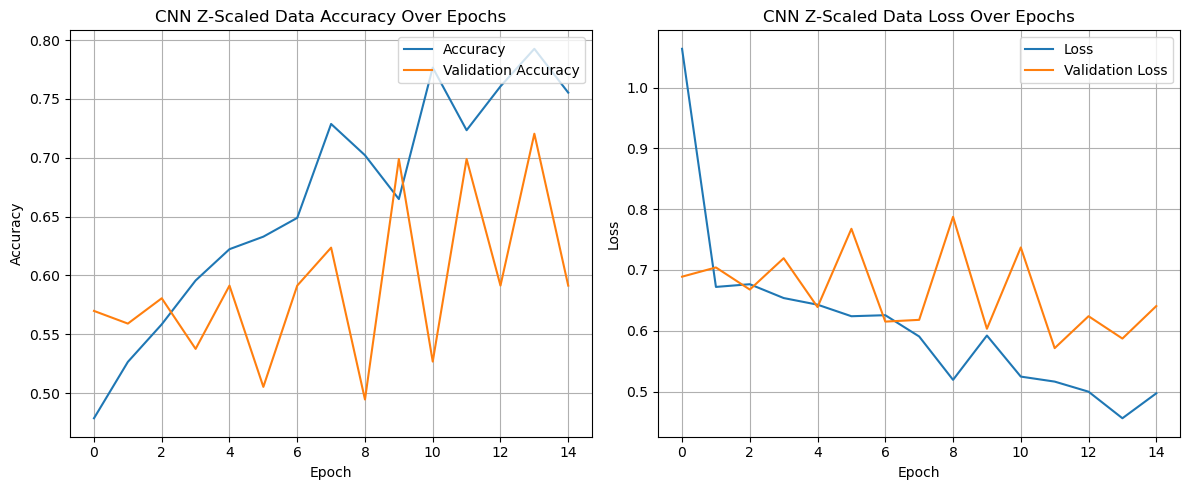

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 9
Batch Size: 32
Final Training Accuracy: 0.665
Final Validation Accuracy: 0.570
Final Training Loss: 0.559
Final Validation Loss: 0.628
Test Accuracy: 0.634
Trainable Params: 646145


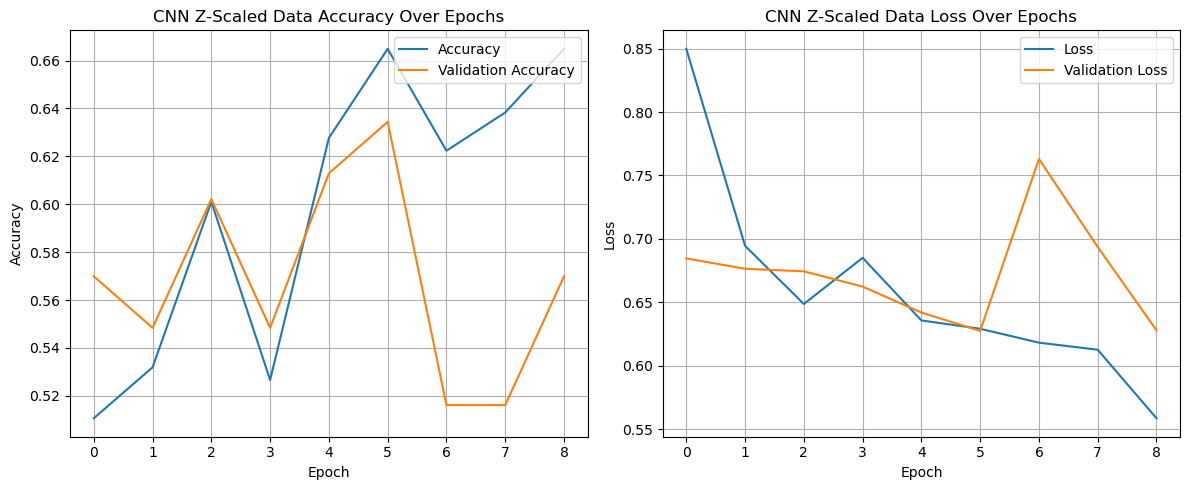

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (3, 3)  (3, 3)      0.5             1   
1  CNN Z-Scaled Data       3        16  (3, 3)  (3, 3)      0.5             1   
2  CNN Z-Scaled Data       3        16  (3, 3)  (3, 3)      0.5             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          512          32              14           2514689  24  36  12  21   
1          256          32              15           1268993  30  35  13  15   
2          128          32               9            646145  15  44   4  30   

   Accuracy  Precision    Recall        F1  
0  0.645161   0.666667  0.533333  0.592593  
1  0.698925   0.697674  0.666667  0.681818  
2  0.634409   0.789474  0.333333  0.468750

In [68]:
layers = 3
channels = 16
k_size = (3, 3)
pool = (3,3)
act = 'relu'
dropout = 0.5
dense_layers = 1
units_list = [512, 256, 128]
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 32
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for units in units_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: 256 units in the hidden dense layer gave us higher accuracy, better recall and F1 score. 

### K Size Optimization

CNN Z-Scaled Data with 3 layer(s), 16 channels, (3, 3) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 16
Batch Size: 32
Final Training Accuracy: 0.819
Final Validation Accuracy: 0.570
Final Training Loss: 0.444
Final Validation Loss: 0.675
Test Accuracy: 0.667
Trainable Params: 1268993


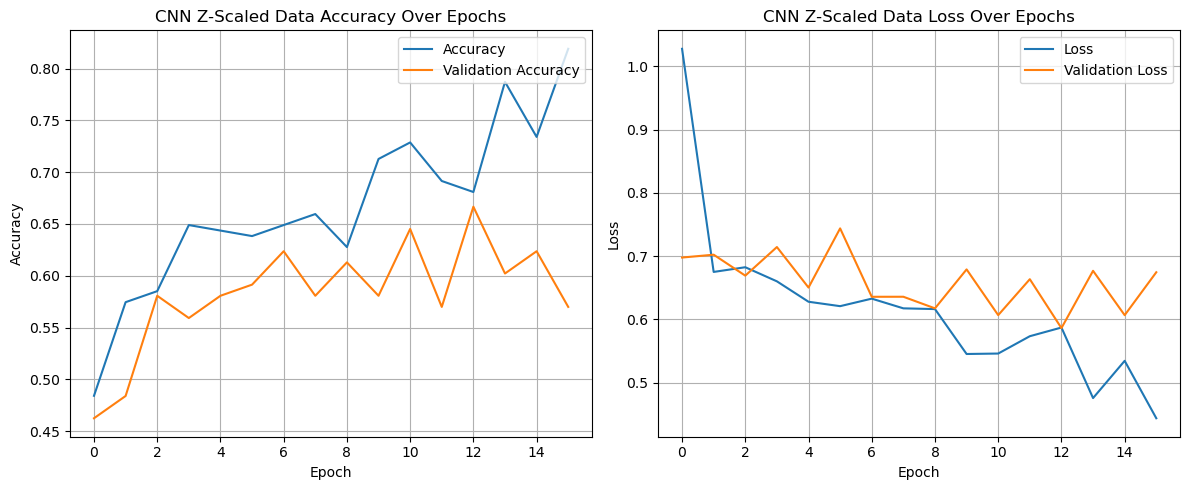

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (4, 4) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 11
Batch Size: 32
Final Training Accuracy: 0.676
Final Validation Accuracy: 0.527
Final Training Loss: 0.557
Final Validation Loss: 0.667
Test Accuracy: 0.645
Trainable Params: 1287025


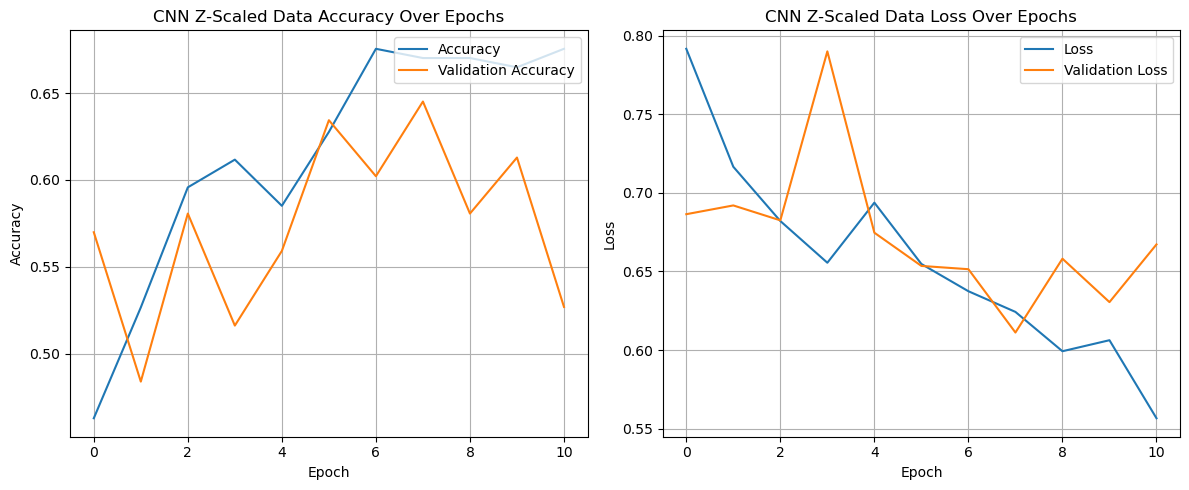

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 15
Batch Size: 32
Final Training Accuracy: 0.782
Final Validation Accuracy: 0.656
Final Training Loss: 0.518
Final Validation Loss: 0.632
Test Accuracy: 0.677
Trainable Params: 1310209


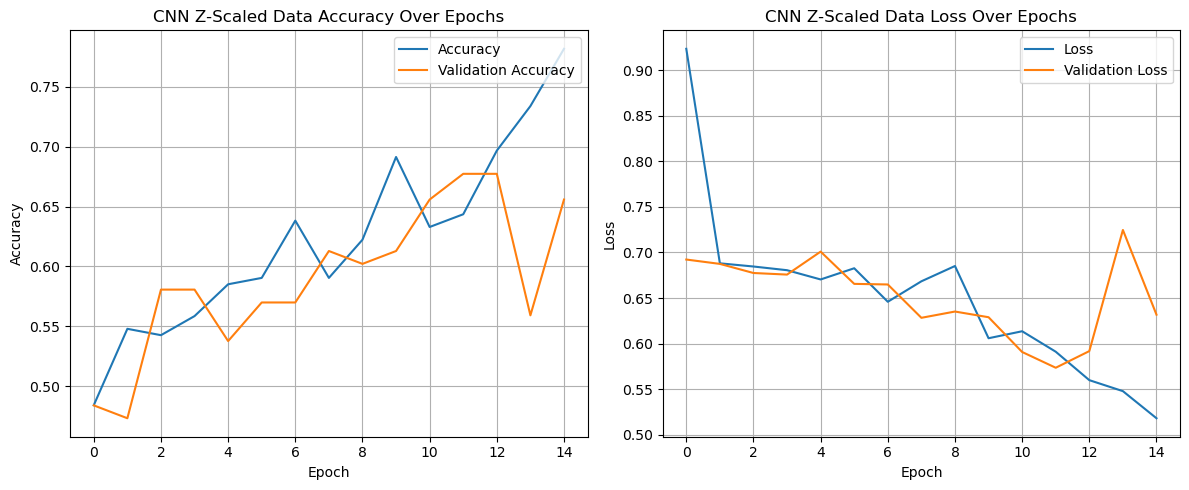

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (3, 3)  (3, 3)      0.5             1   
1  CNN Z-Scaled Data       3        16  (4, 4)  (3, 3)      0.5             1   
2  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          256          32              16           1268993  27  35  13  18   
1          256          32              11           1287025  18  42   6  27   
2          256          32              15           1310209  29  34  14  16   

   Accuracy  Precision    Recall        F1  
0  0.666667   0.675000  0.600000  0.635294  
1  0.645161   0.750000  0.400000  0.521739  
2  0.677419   0.674419  0.644444  0.659091

In [72]:
layers = 3
channels = 16
k_size_list = [(3, 3), (4,4), (5,5)]
pool = (3,3)
act = 'relu'
dropout = 0.5
dense_layers = 1
units = 256
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 32
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for k_size in k_size_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: (5,5) performed best in terms of accuracy, recall and F1 score

### Batch Optimization

CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=16, Epoch=100)
Epochs Trained: 11
Batch Size: 16
Final Training Accuracy: 0.745
Final Validation Accuracy: 0.591
Final Training Loss: 0.496
Final Validation Loss: 0.671
Test Accuracy: 0.613
Trainable Params: 1310209


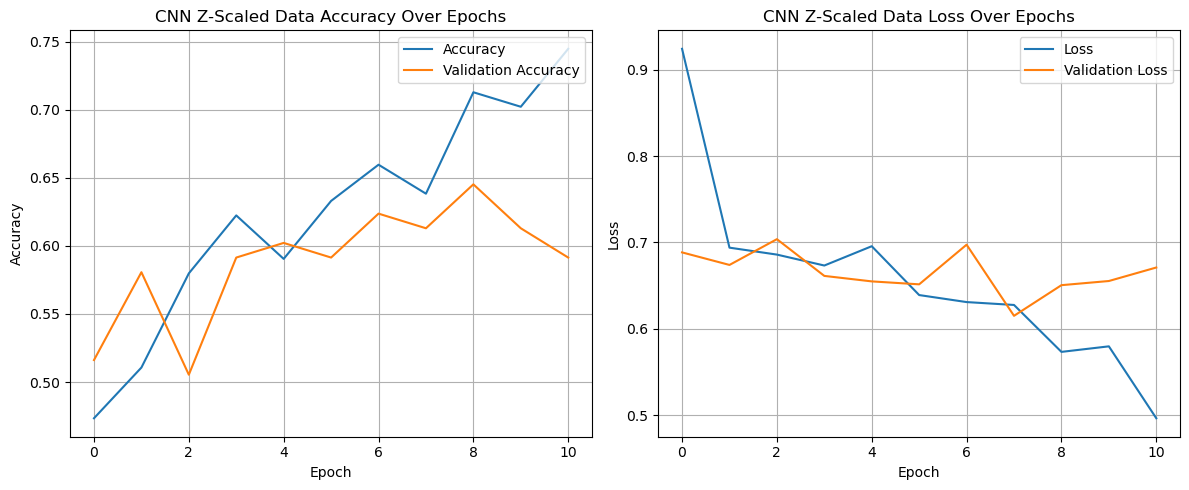

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=32, Epoch=100)
Epochs Trained: 14
Batch Size: 32
Final Training Accuracy: 0.771
Final Validation Accuracy: 0.602
Final Training Loss: 0.545
Final Validation Loss: 0.636
Test Accuracy: 0.613
Trainable Params: 1310209


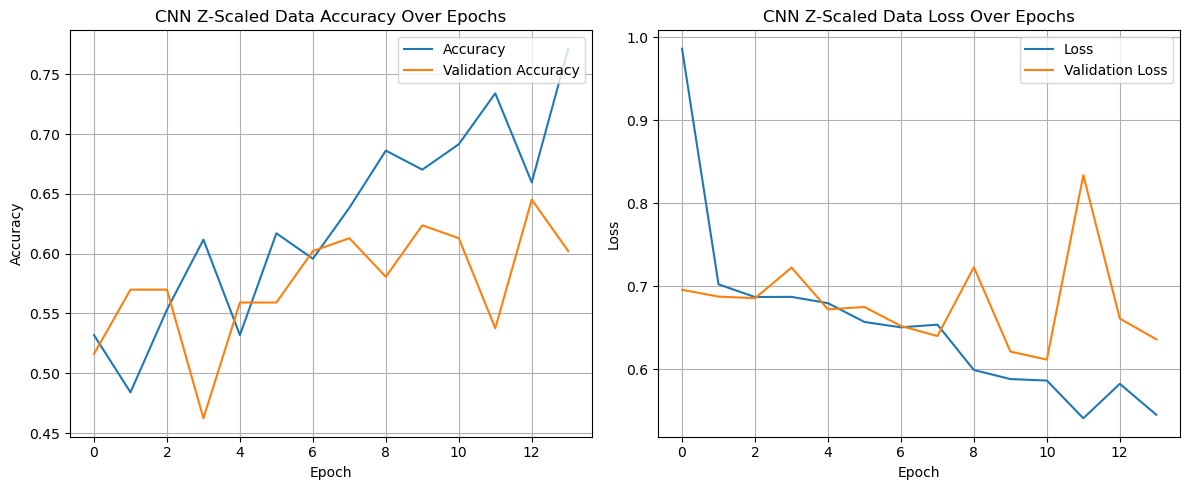

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 22
Batch Size: 64
Final Training Accuracy: 0.745
Final Validation Accuracy: 0.548
Final Training Loss: 0.498
Final Validation Loss: 0.675
Test Accuracy: 0.688
Trainable Params: 1310209


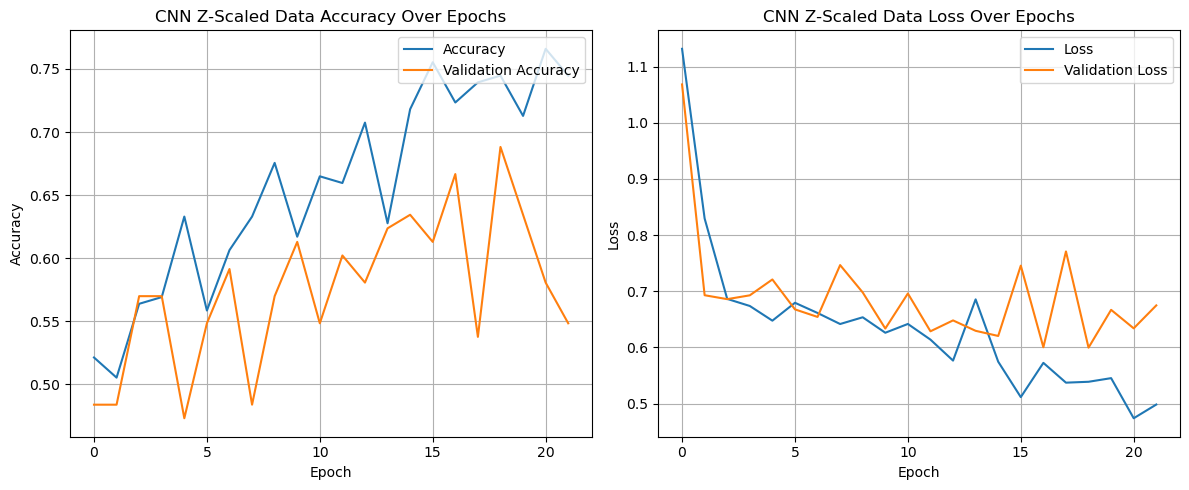

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             1   
1  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             1   
2  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          256          16              11           1310209  18  39   9  27   
1          256          32              14           1310209  18  39   9  27   
2          256          64              22           1310209  36  28  20   9   

   Accuracy  Precision  Recall        F1  
0  0.612903   0.666667     0.4  0.500000  
1  0.612903   0.666667     0.4  0.500000  
2  0.688172   0.642857     0.8  0.712871

In [76]:
layers = 3
channels = 16
k_size = (5,5)
pool = (3,3)
act = 'relu'
dropout = 0.5
dense_layers = 1
units = 256
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch_list = [16, 32, 64]
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for batch in batch_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: Batch size of 64 provided better accuracy, recall, and F1 scores. 

### Channel Optimization 

CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 20
Batch Size: 64
Final Training Accuracy: 0.681
Final Validation Accuracy: 0.591
Final Training Loss: 0.586
Final Validation Loss: 0.704
Test Accuracy: 0.634
Trainable Params: 1310209


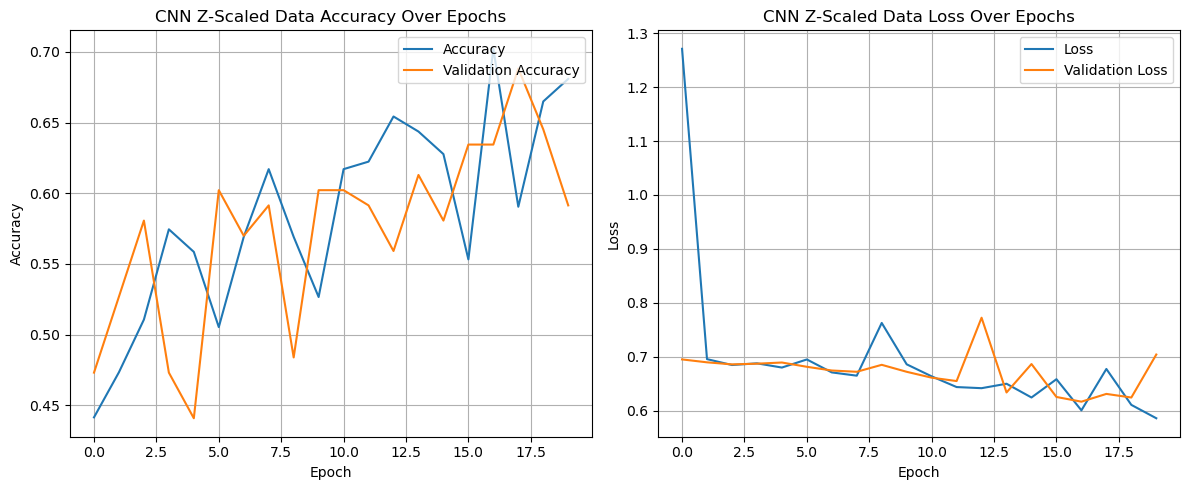

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
CNN Z-Scaled Data with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 20
Batch Size: 64
Final Training Accuracy: 0.617
Final Validation Accuracy: 0.602
Final Training Loss: 0.655
Final Validation Loss: 0.644
Test Accuracy: 0.613
Trainable Params: 2747905


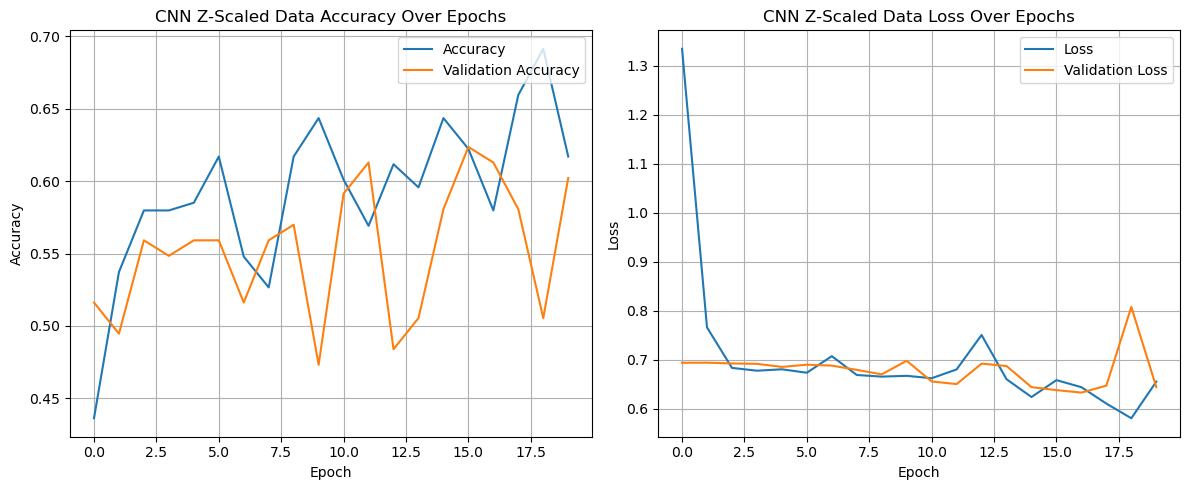

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             1   
1  CNN Z-Scaled Data       3        32  (5, 5)  (3, 3)      0.5             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          256          64              20           1310209  16  43   5  29   
1          256          64              20           2747905  16  41   7  29   

   Accuracy  Precision    Recall        F1  
0  0.634409   0.761905  0.355556  0.484848  
1  0.612903   0.695652  0.355556  0.470588

In [79]:
layers = 3
channels_list = [16, 32]
k_size = (5,5)
pool = (3,3)
act = 'relu'
dropout = 0.5
dense_layers = 1
units = 256
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch_list = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for channels in channels_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: Keep the Number of chanels the same. 

### Dense Layer tuning

CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 26
Batch Size: 64
Final Training Accuracy: 0.718
Final Validation Accuracy: 0.505
Final Training Loss: 0.564
Final Validation Loss: 1.049
Test Accuracy: 0.634
Trainable Params: 1310209


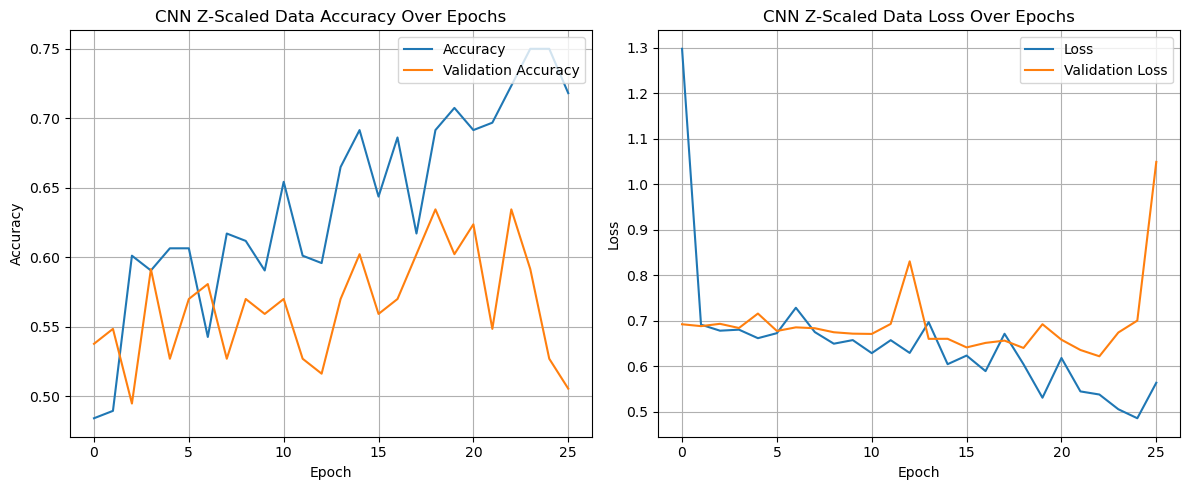

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 2 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 20
Batch Size: 64
Final Training Accuracy: 0.707
Final Validation Accuracy: 0.667
Final Training Loss: 0.590
Final Validation Loss: 0.607
Test Accuracy: 0.656
Trainable Params: 1342977


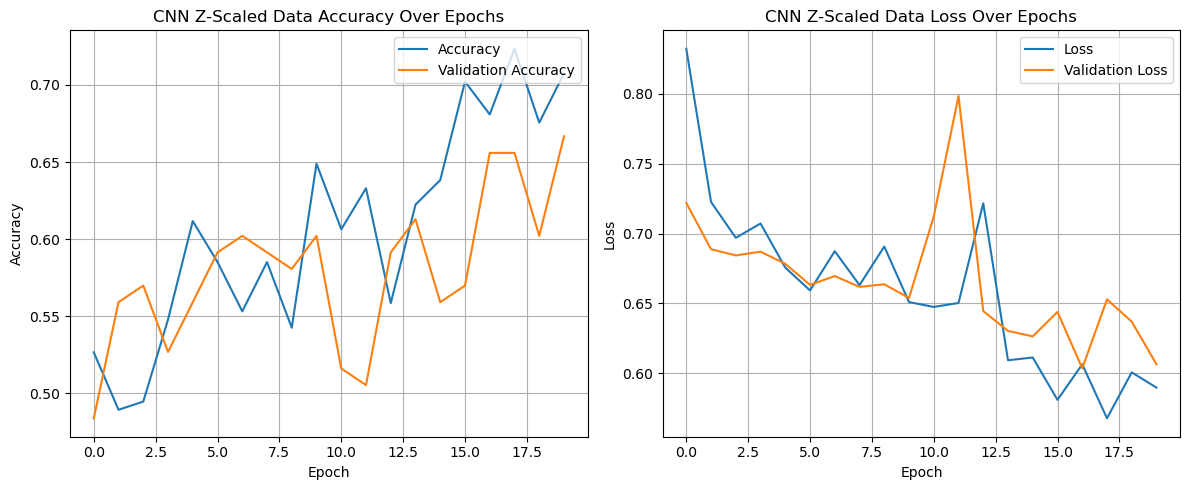

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 3 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 18
Batch Size: 64
Final Training Accuracy: 0.601
Final Validation Accuracy: 0.538
Final Training Loss: 0.646
Final Validation Loss: 0.712
Test Accuracy: 0.602
Trainable Params: 1351169


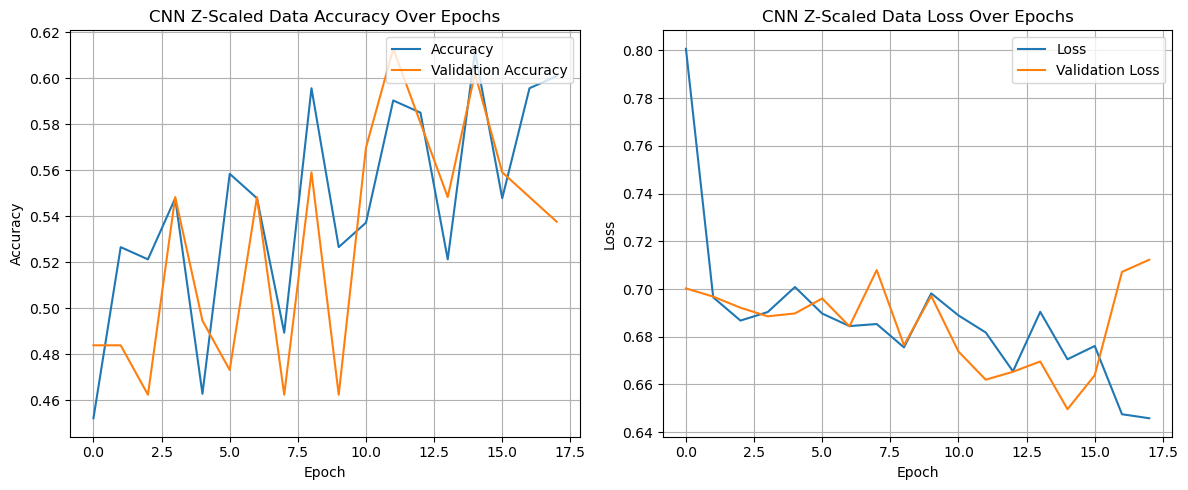

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             1   
1  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             2   
2  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             3   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          256          64              26           1310209  21  38  10  24   
1          256          64              20           1342977  24  37  11  21   
2          256          64              18           1351169  18  38  10  27   

   Accuracy  Precision    Recall        F1  
0  0.634409   0.677419  0.466667  0.552632  
1  0.655914   0.685714  0.533333  0.600000  
2  0.602151   0.642857  0.400000  0.493151

In [93]:
layers = 3
channels = 16
k_size = (5,5)
pool = (3,3)
act = 'relu'
dropout = 0.5
dense_layers_list = [1, 2, 3]
units = 256
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_results = []

for dense_layers in dense_layers_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: Dense layers should be 1 at 256 units

### Dropout Optimization

CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.5 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 25
Batch Size: 64
Final Training Accuracy: 0.777
Final Validation Accuracy: 0.624
Final Training Loss: 0.511
Final Validation Loss: 0.632
Test Accuracy: 0.624
Trainable Params: 1310209


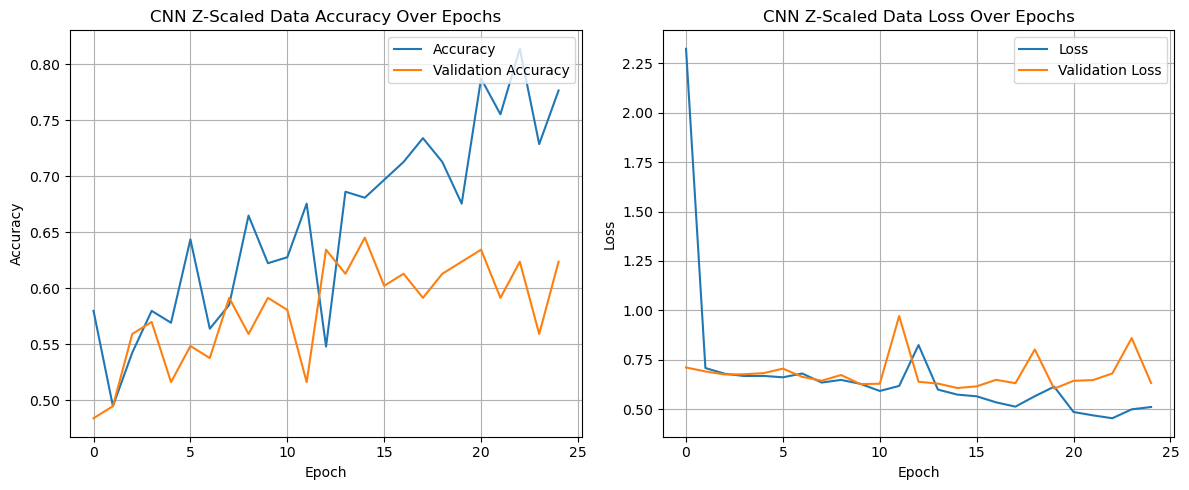

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.4 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 21
Batch Size: 64
Final Training Accuracy: 0.734
Final Validation Accuracy: 0.581
Final Training Loss: 0.583
Final Validation Loss: 0.661
Test Accuracy: 0.591
Trainable Params: 1310209


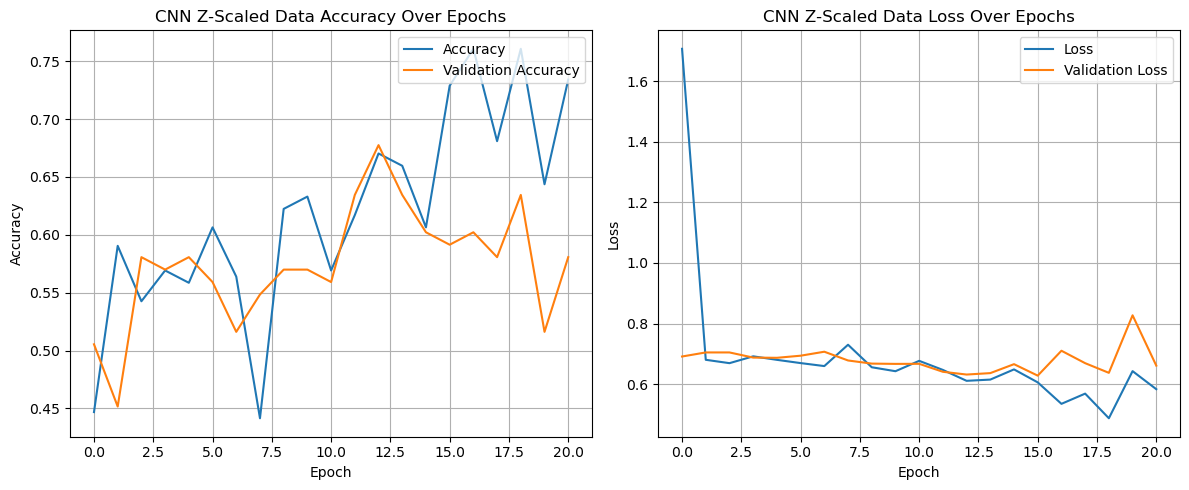

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.3 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 25
Batch Size: 64
Final Training Accuracy: 0.771
Final Validation Accuracy: 0.613
Final Training Loss: 0.503
Final Validation Loss: 0.626
Test Accuracy: 0.699
Trainable Params: 1310209


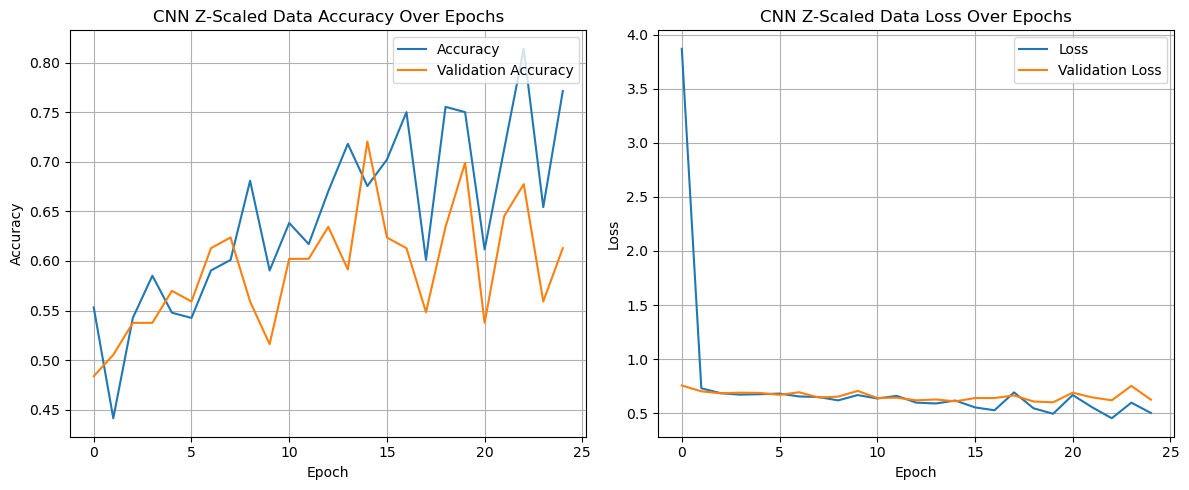

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.5             1   
1  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.4             1   
2  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.3             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          256          64              25           1310209  26  32  16  19   
1          256          64              21           1310209  28  27  21  17   
2          256          64              25           1310209  33  32  16  12   

   Accuracy  Precision    Recall        F1  
0  0.623656   0.619048  0.577778  0.597701  
1  0.591398   0.571429  0.622222  0.595745  
2  0.698925   0.673469  0.733333  0.702128

In [97]:
layers = 3
channels = 16
k_size = (5,5)
pool = (3,3)
act = 'relu'
dropout_list = [0.5, 0.4, 0.3]
dense_layers = 1
units = 256
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_results = []

for dropout in dropout_list:
    model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, l, m)
    history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

#### Observation: Dropout at 0.3 improved accuracy, recall and F1 score. 

## Final Model

CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.3 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 16
Batch Size: 64
Final Training Accuracy: 0.723
Final Validation Accuracy: 0.634
Final Training Loss: 0.559
Final Validation Loss: 0.665
Test Accuracy: 0.613
Trainable Params: 1310209


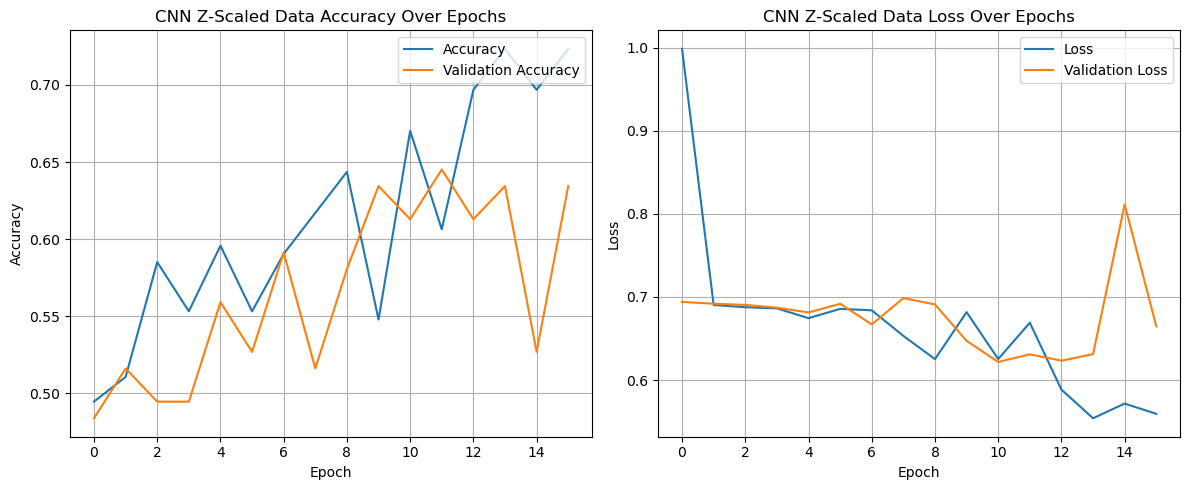

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.3             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  TP  TN  FP  FN  \
0          256          64              16           1310209  29  28  20  16   

   Accuracy  Precision    Recall        F1  
0  0.612903   0.591837  0.644444  0.617021

In [106]:
layers = 3
channels = 16
k_size = (5,5)
pool = (3,3)
act = 'relu'
dropout = 0.3
dense_layers = 1
units = 256
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_results = []


model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
model_cnn = seq_model_compile(title, model, opt, l, m)
history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)
y_pred_probs = model_cnn.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

# Test on different set of birds

CNN Z-Scaled Data with 3 layer(s), 16 channels, (5, 5) kernel size, (3, 3) pool size, relu activation, 0.3 dropout, 1 hidden dense layer(s)
CNN Z-Scaled Data Compiled (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)
CNN Z-Scaled Data Tested (Optimizer: rmsprop, Loss: binary_crossentropy, Metric: accuracy)

CNN Z-Scaled Data (Batch Size=64, Epoch=100)
Epochs Trained: 19
Batch Size: 64
Final Training Accuracy: 0.989
Final Validation Accuracy: 0.965
Final Training Loss: 0.025
Final Validation Loss: 0.070
Test Accuracy: 0.978
Trainable Params: 1310209


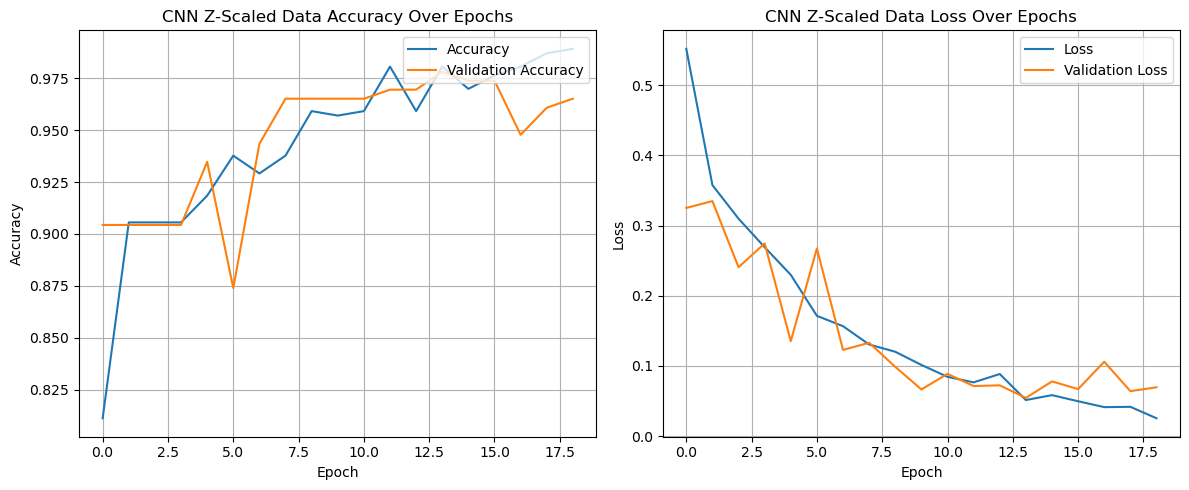

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Z-Scaled Data       3        16  (5, 5)  (3, 3)      0.3             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params   TP  TN  FP  FN  \
0          256          64              19           1310209  207  18   4   1   

   Accuracy  Precision    Recall        F1  
0  0.978261   0.981043  0.995192  0.988067

In [111]:
X_train, X_test, y_train, y_test = generate_binomial_data(['amecro', 'houspa'])
mean = np.mean(X_train)
std = np.std(X_train)

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

layers = 3
channels = 16
k_size = (5,5)
pool = (3,3)
act = 'relu'
dropout = 0.3
dense_layers = 1
units = 256
opt = 'rmsprop'
l = 'binary_crossentropy'
m = 'accuracy'
title = 'CNN Z-Scaled Data'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_results = []


model = build_cnn_model(title, layers, channels, k_size, pool, act, dropout, dense_layers, units)
model_cnn = seq_model_compile(title, model, opt, l, m)
history = cnn_model(title, model_cnn, X_train_scaled, X_test_scaled, y_train, y_test, epoch, batch, early_stop)
y_pred_probs = model_cnn.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cnn_results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

cnn_results_df = pd.DataFrame(cnn_results)
display(cnn_results_df)

In [115]:
# Lock Model
model_cnn.save('final_bird_model.keras')

# Multi Class Prediction

In [140]:
def generate_multiclass_data(full_bird):
    X_list = []
    y_list = []

    for species in full_bird.keys():
        specs = full_bird[species]
        X_list.append(specs)
        y_list.extend([species] * specs.shape[0])

    X = np.concatenate(X_list, axis=0)
    y = np.array(y_list)
    X = X[..., np.newaxis]

    label = LabelEncoder()
    y_encoded = label.fit_transform(y)
    y_cat = to_categorical(y_encoded)


    X_flat = X.reshape(X.shape[0], -1)
    mean = X_flat.mean()
    std = X_flat.std()
    X = (X - mean) / std

    return train_test_split(X, y_cat, test_size=0.33, random_state=13, stratify=y_encoded), label

# Build CNN model
def build_multi_cnn_model(name, layers, channels, k_size, pool, act, drop, dense, u):
    print(f'{name} with {layers} layer(s), {channels} channels, {k_size} kernel size, {pool} pool, {act} activation, {drop} dropout, {dense} dense layer(s)')
    
    model = Sequential()
    model.add(Input(shape=(128, 517, 1)))
    model.add(Conv2D(filters=channels, kernel_size=k_size, padding='same', activation=act))
    model.add(MaxPooling2D(pool_size=pool))

    for i in range(1, layers):
        model.add(Conv2D(filters=channels * (2**i), kernel_size=k_size, padding='same', activation=act))
        model.add(MaxPooling2D(pool_size=pool))

    model.add(Flatten())
    model.add(Dropout(drop))

    units = u
    for j in range(dense):
        units = int(units)
        model.add(Dense(units=units, activation=act))
        if drop > 0:
            model.add(Dropout(drop)) 
        units = units/2  

    model.add(Dense(12, activation='softmax'))
    return model

# Compile Model
def seq_model_compile(title, model, opt, l, m):
    print(f'{title} (Optimizer: {opt}, Loss: {l}, Metric: {m})')
    model.compile(optimizer=opt, loss=l, metrics=[m])
    return model

# Train and evaluate
def cnn_model(title, model, xtrain, xtest, ytrain, ytest, e, b, stop):
    print(f'{title} (Batch Size={b}, Epoch={e})')
    history = model.fit(xtrain, ytrain, 
                        epochs=e, 
                        batch_size=b,
                        validation_data=(xtest, ytest),
                        callbacks=[stop],
                        verbose=0)
    plot_training_history(history, title)
    return history

def cnn_multi_metrics(model, X_test, y_test_cat, layers, channels, label_encoder):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)

    print(f"\nAccuracy: {acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))

    

In [136]:
# Load and prepare data
(X_train, X_test, y_train, y_test), label_encoder = generate_multiclass_data(full_bird)

### Number of layers optimizations

CNN Multi-Class with 1 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.3 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


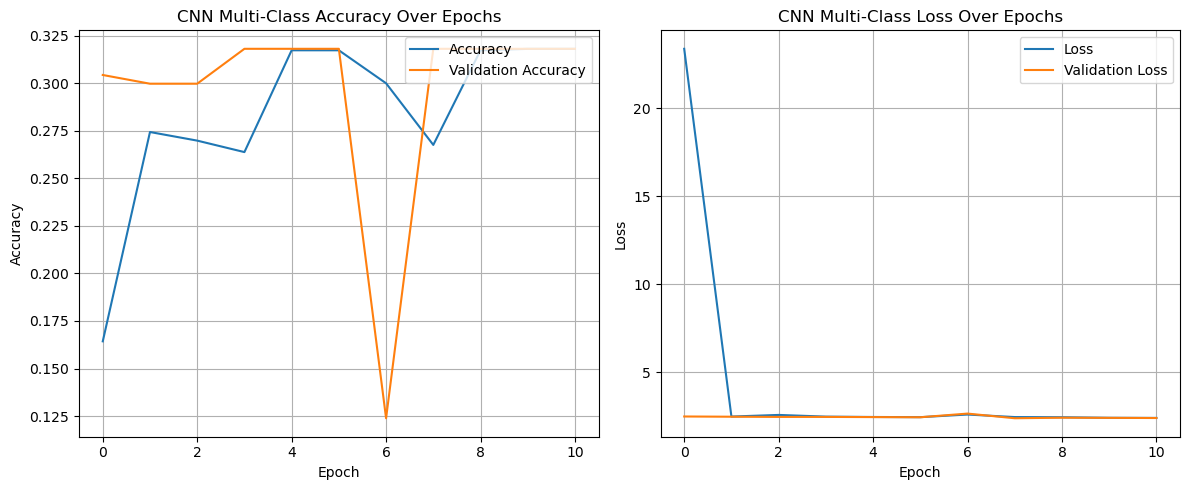

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
CNN Multi-Class with 2 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.3 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


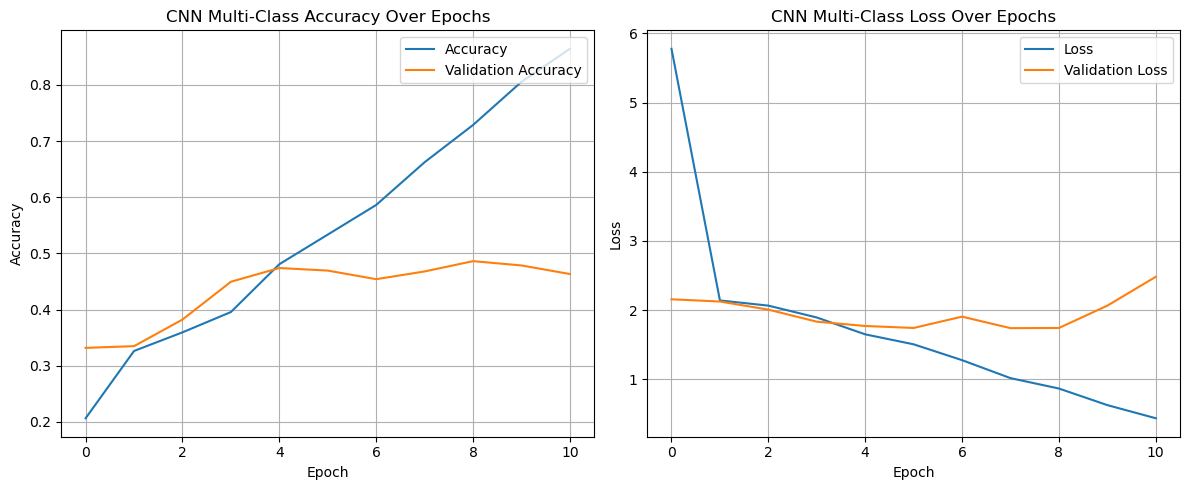

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.3 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


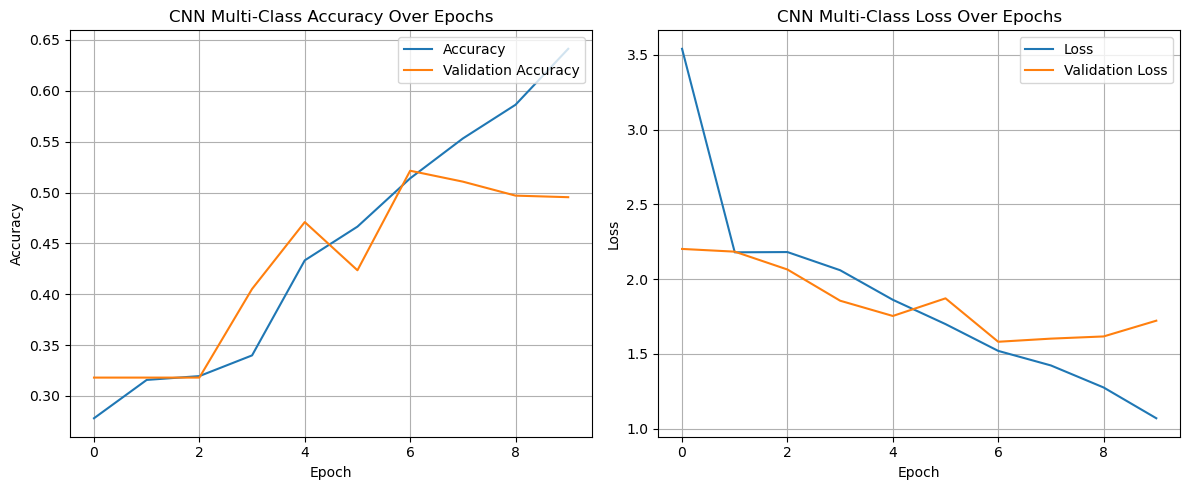

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Multi-Class       1        32  (5, 5)  (3, 3)      0.3             1   
1  CNN Multi-Class       2        32  (5, 5)  (3, 3)      0.3             1   
2  CNN Multi-Class       3        32  (5, 5)  (3, 3)      0.3             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  Accuracy  \
0          256          64              11          59183180  0.318043   
1          256          64              11          13129868  0.467890   
2          256          64              10           2750732  0.521407   

   Macro F1  Macro Precision  Macro Recall  
0  0.040217         0.026504      0.083333  
1  0.281314         0.358226      0.277578  
2  0.336088         0.412150      0.337448

In [138]:
channels = 32
layers_list = [1,2,3]
k_size = (5, 5)
pool = (3, 3)
act = 'relu'
drop = 0.3
dense_layers = 1
units = 256
opt = 'rmsprop'
loss = 'categorical_crossentropy'
metric = 'accuracy'
title = 'CNN Multi-Class'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


results = []

for layers in layers_list:
    model = build_multi_cnn_model(title, layers, channels, k_size, pool, act, drop, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, loss, metric)
    history = cnn_model(title, model_cnn, X_train, X_test, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

    results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'Accuracy': acc,
        'Macro F1': f1,
        'Macro Precision': precision,
        'Macro Recall': recall,
    })

results_df = pd.DataFrame(results)
display(results_df)

### Number of Dense Layers Optimization

CNN Multi-Class with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.3 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


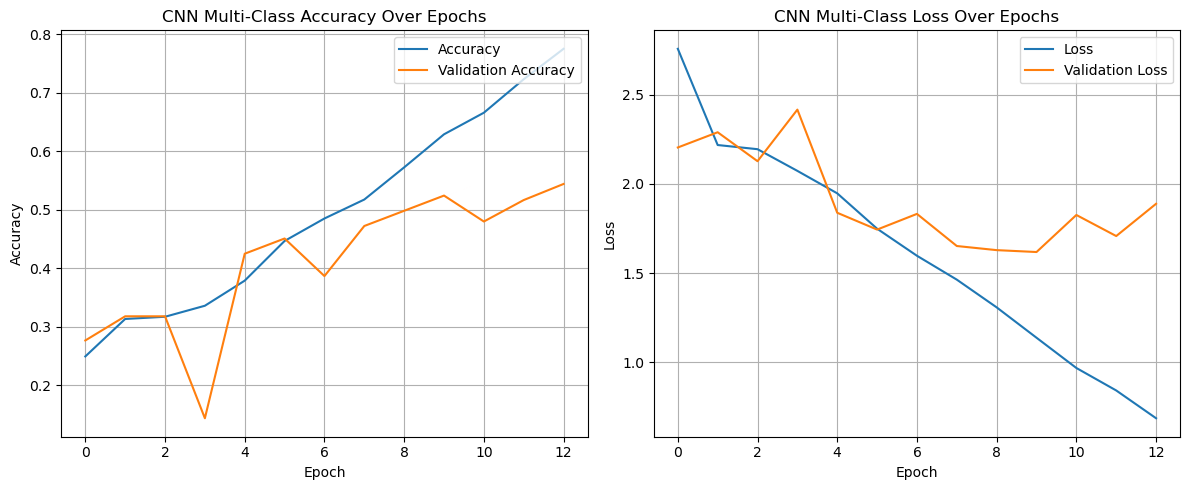

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.3 dropout, 2 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


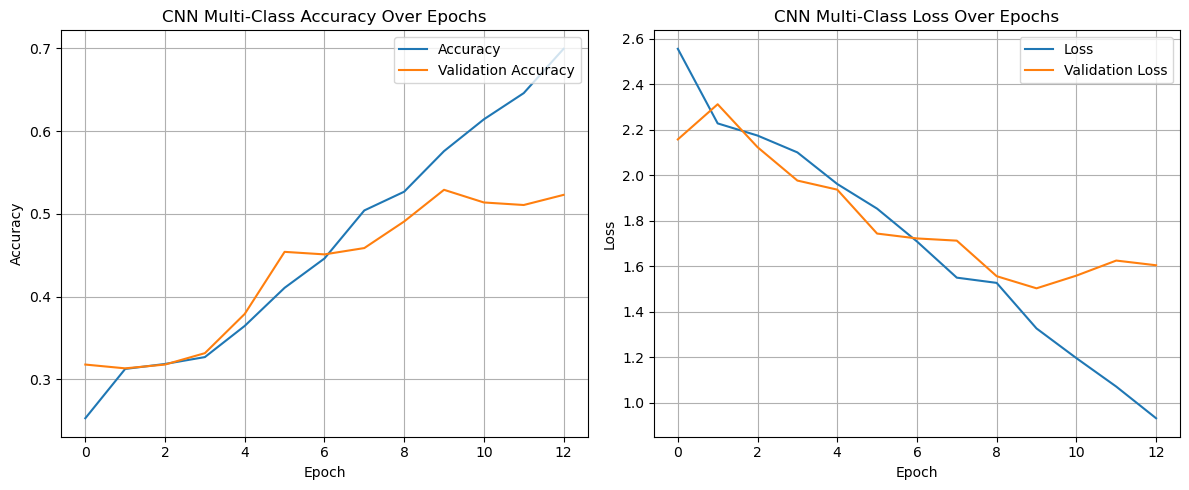

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Multi-Class       3        32  (5, 5)  (3, 3)      0.3             1   
1  CNN Multi-Class       3        32  (5, 5)  (3, 3)      0.3             2   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  Accuracy  \
0          256          64              13           2750732  0.524465   
1          256          64              13           2782092  0.529052   

   Macro F1  Macro Precision  Macro Recall  
0  0.352835         0.415234      0.362651  
1  0.321278         0.344708      0.345752

In [142]:
channels = 32
layers = 3
k_size = (5, 5)
pool = (3, 3)
act = 'relu'
drop = 0.3
dense_layers_list = [1, 2]
units = 256
opt = 'rmsprop'
loss = 'categorical_crossentropy'
metric = 'accuracy'
title = 'CNN Multi-Class'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


results = []

for dense_layers in dense_layers_list:
    model = build_multi_cnn_model(title, layers, channels, k_size, pool, act, drop, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, loss, metric)
    history = cnn_model(title, model_cnn, X_train, X_test, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

    results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'Accuracy': acc,
        'Macro F1': f1,
        'Macro Precision': precision,
        'Macro Recall': recall,
    })

results_df = pd.DataFrame(results)
display(results_df)

#### Observations: 1 dense layer is enough for the model

### Dropout Optimization

CNN Multi-Class with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.2 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


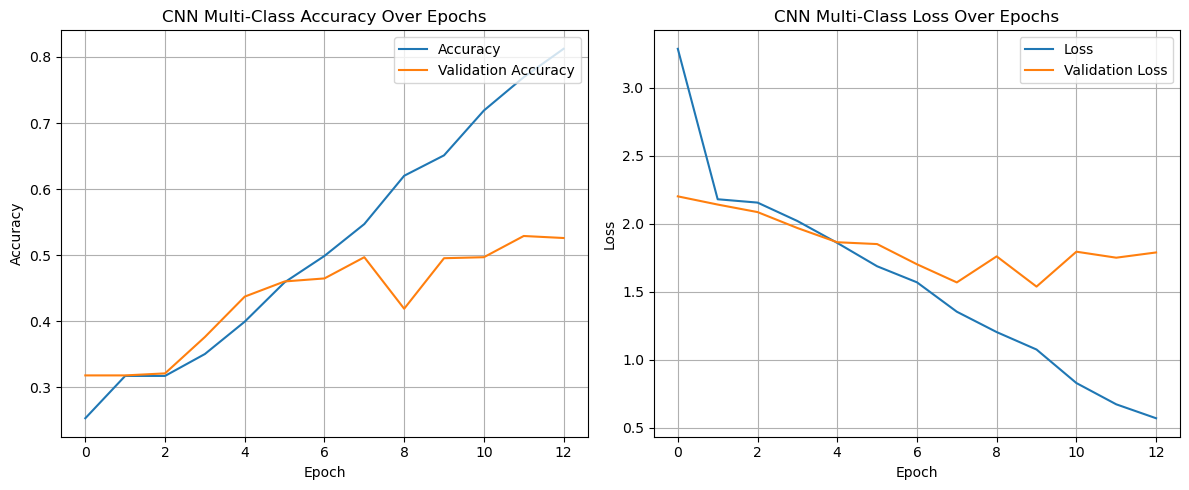

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.3 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


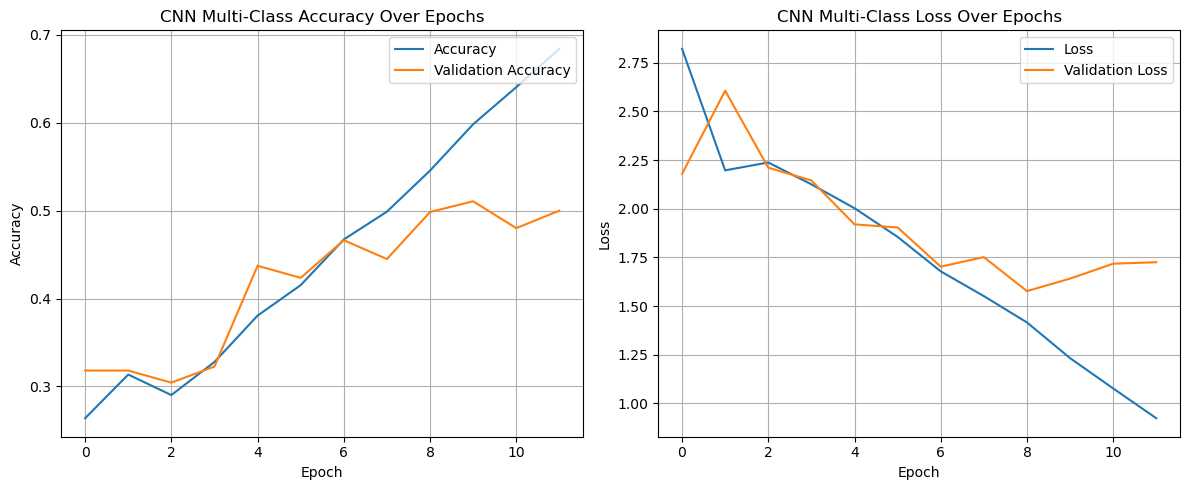

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


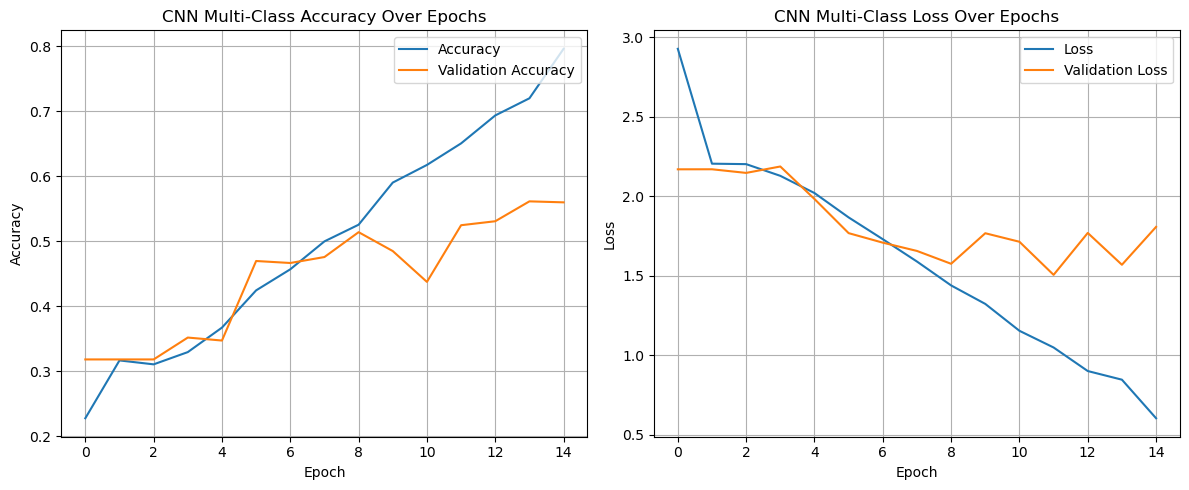

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Multi-Class       3        32  (5, 5)  (3, 3)      0.2             1   
1  CNN Multi-Class       3        32  (5, 5)  (3, 3)      0.3             1   
2  CNN Multi-Class       3        32  (5, 5)  (3, 3)      0.4             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  Accuracy  \
0          256          64              13           2750732  0.495413   
1          256          64              12           2750732  0.498471   
2          256          64              15           2750732  0.524465   

   Macro F1  Macro Precision  Macro Recall  
0  0.338714         0.368131      0.343732  
1  0.301184         0.326837      0.323927  
2  0.350077         0.398075      0.338919

In [149]:
channels = 32
layers = 3
k_size = (5, 5)
pool = (3, 3)
act = 'relu'
drop_list = [0.2, 0.3, 0.4]
dense_layers = 1
units = 256
opt = 'rmsprop'
loss = 'categorical_crossentropy'
metric = 'accuracy'
title = 'CNN Multi-Class'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


results = []

for drop in drop_list:
    model = build_multi_cnn_model(title, layers, channels, k_size, pool, act, drop, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, loss, metric)
    history = cnn_model(title, model_cnn, X_train, X_test, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

    results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': drop,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'Accuracy': acc,
        'Macro F1': f1,
        'Macro Precision': precision,
        'Macro Recall': recall,
    })

results_df = pd.DataFrame(results)
display(results_df)

#### Observations: Setting dropout to 0.4 improved accuracy, F1 and precision. 

### K Size Optimization

CNN Multi-Class with 3 layer(s), 32 channels, (3, 3) kernel size, (3, 3) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


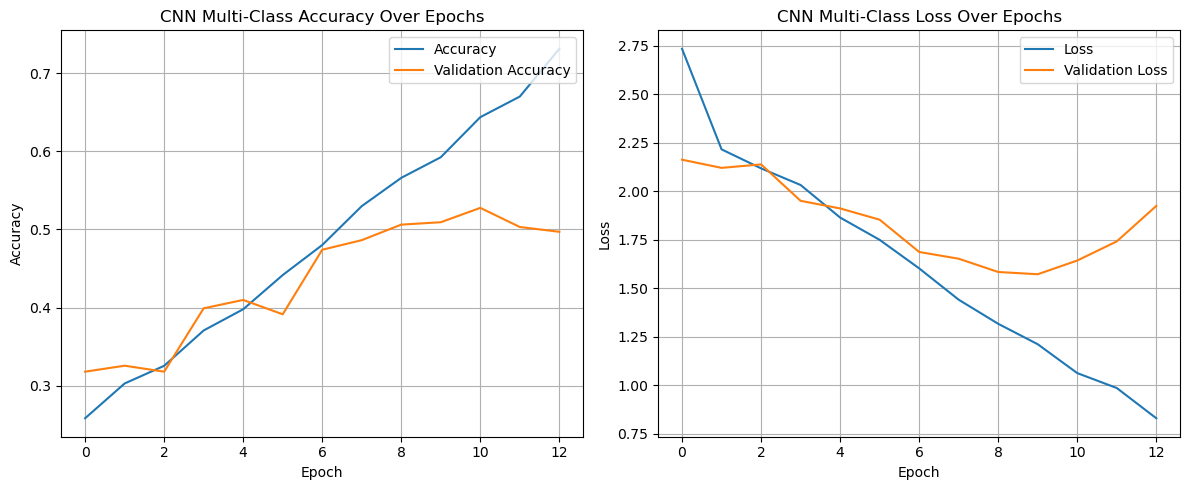

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (5, 5) kernel size, (3, 3) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


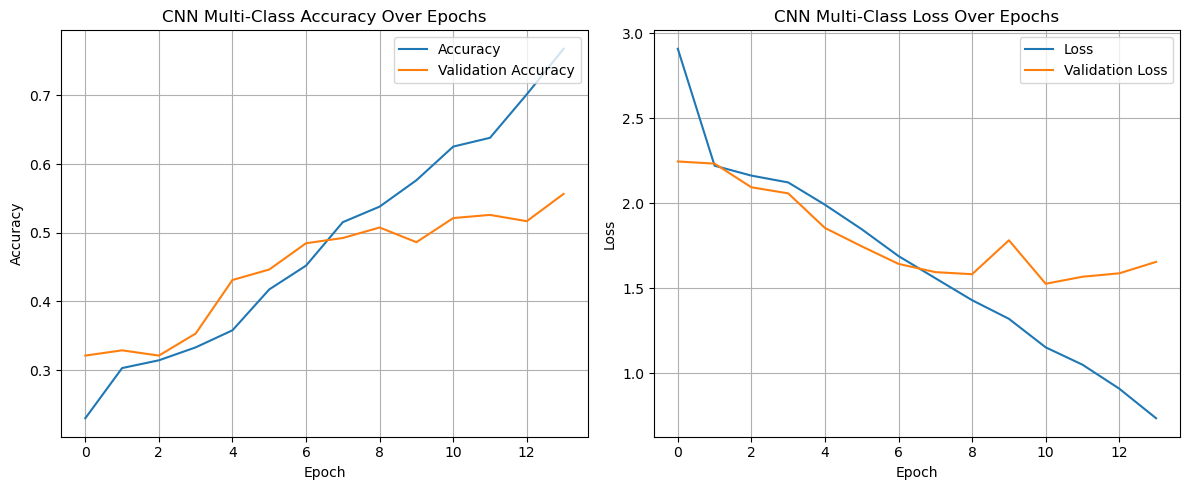

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (7, 7) kernel size, (3, 3) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


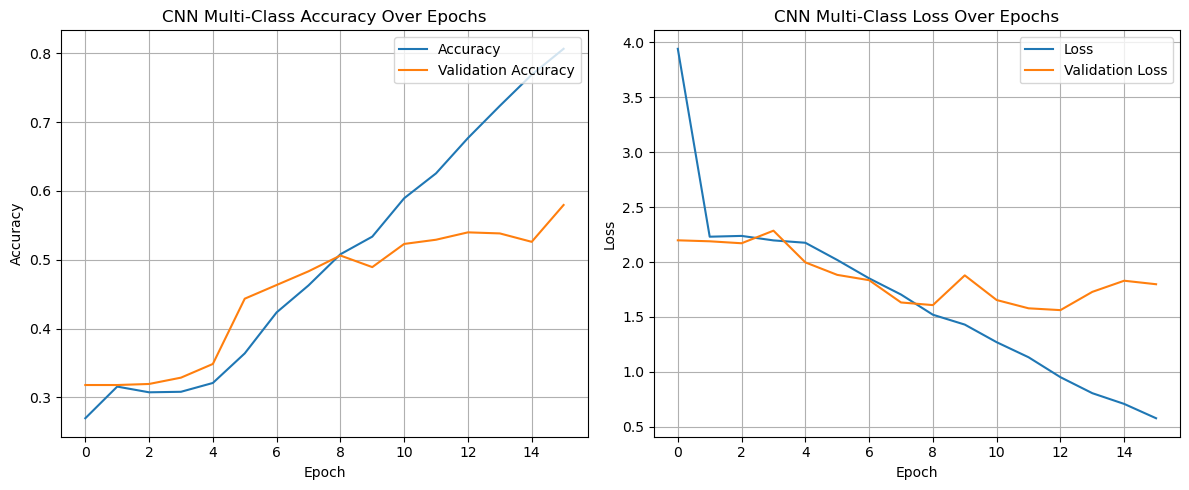

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Multi-Class       3        32  (3, 3)  (3, 3)      0.3             1   
1  CNN Multi-Class       3        32  (5, 5)  (3, 3)      0.3             1   
2  CNN Multi-Class       3        32  (7, 7)  (3, 3)      0.3             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  Accuracy  \
0          256          64              13           2586380  0.509174   
1          256          64              14           2750732  0.521407   
2          256          64              16           2997260  0.539755   

   Macro F1  Macro Precision  Macro Recall  
0  0.347082         0.421334      0.351126  
1  0.352820         0.410685      0.346536  
2  0.386743         0.385072      0.399491

In [155]:
channels = 32
layers = 3
k_size_list = [(3, 3), (5, 5), (7, 7)]
pool = (3, 3)
act = 'relu'
drop = 0.4
dense_layers = 1
units = 256
opt = 'rmsprop'
loss = 'categorical_crossentropy'
metric = 'accuracy'
title = 'CNN Multi-Class'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


results = []

for k_size in k_size_list:
    model = build_multi_cnn_model(title, layers, channels, k_size, pool, act, drop, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, loss, metric)
    history = cnn_model(title, model_cnn, X_train, X_test, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

    results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': dropout,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'Accuracy': acc,
        'Macro F1': f1,
        'Macro Precision': precision,
        'Macro Recall': recall,
    })

results_df = pd.DataFrame(results)
display(results_df)

#### Observations: (7,7) kernel size performed the best with higher accuracy, F1 and Recall

### Pool Optimization

CNN Multi-Class with 3 layer(s), 32 channels, (7, 7) kernel size, (2, 2) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


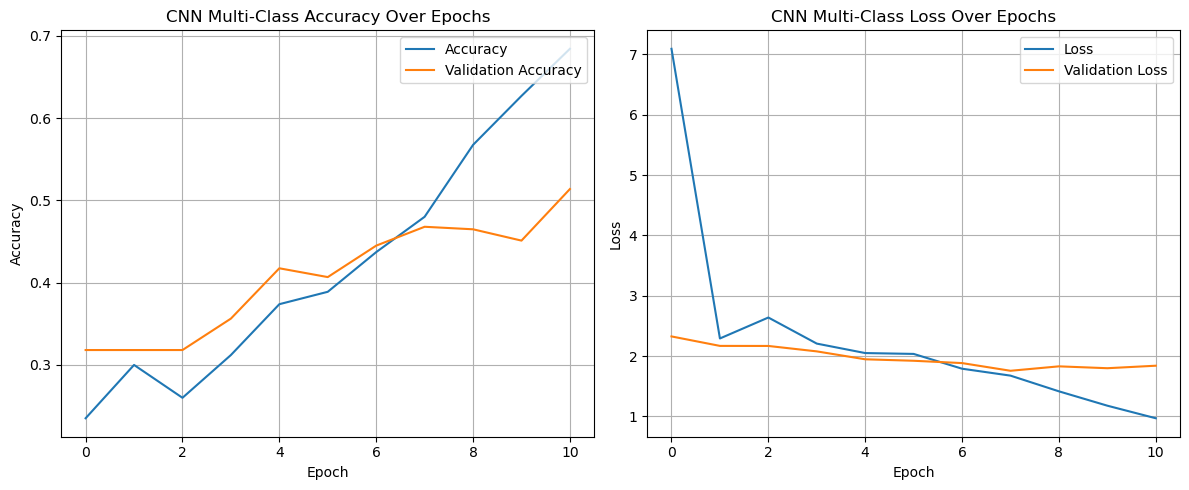

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (7, 7) kernel size, (3, 3) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


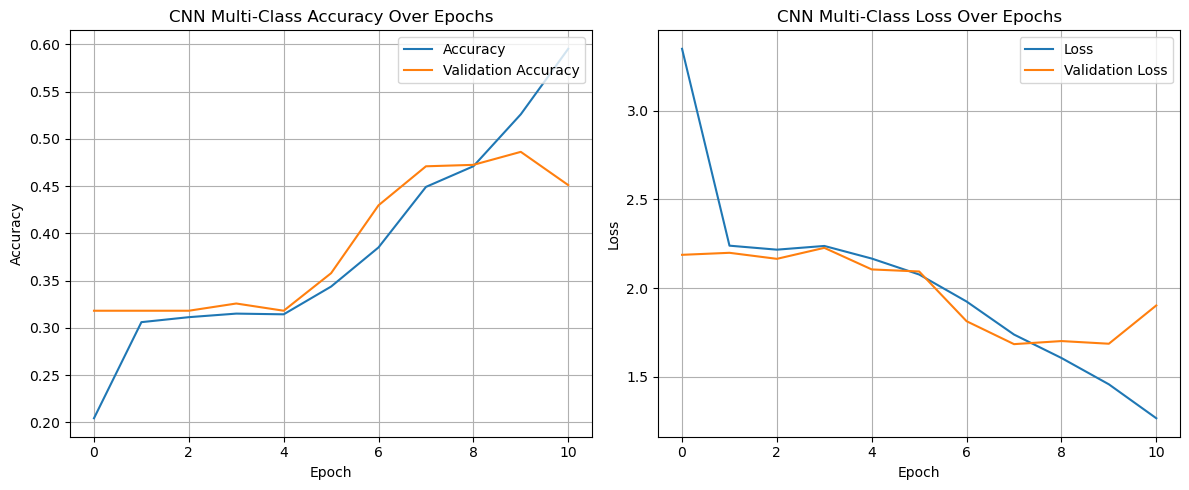

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step
CNN Multi-Class with 3 layer(s), 32 channels, (7, 7) kernel size, (4, 4) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class (Batch Size=64, Epoch=100)


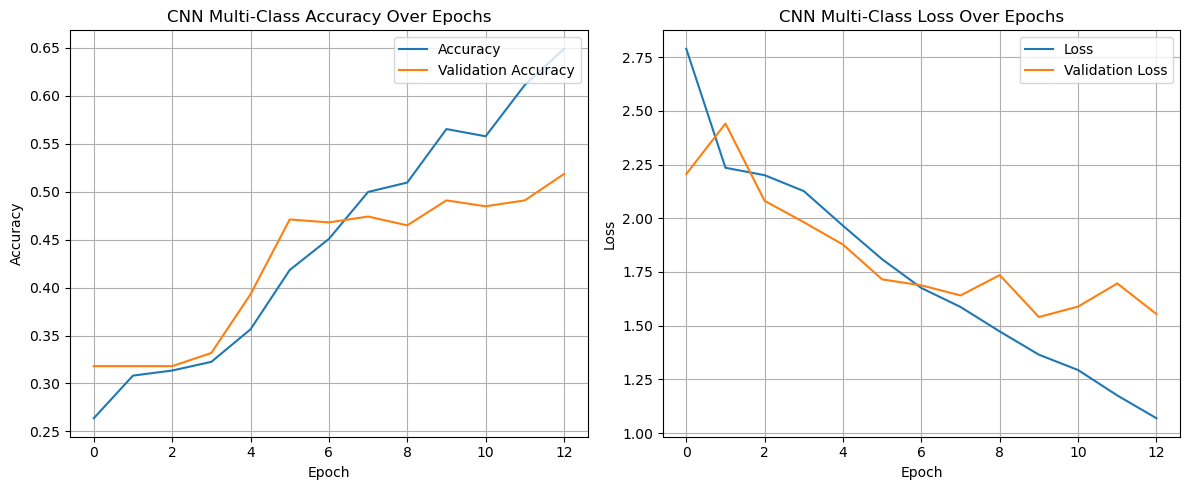

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


Title  Layers  Channels  Kernel    Pool  Dropout  Dense Layers  \
0  CNN Multi-Class       3        32  (7, 7)  (2, 2)      0.4             1   
1  CNN Multi-Class       3        32  (7, 7)  (3, 3)      0.4             1   
2  CNN Multi-Class       3        32  (7, 7)  (4, 4)      0.4             1   

   Dense Units  Batch Size  Epochs Trained  Trainable Params  Accuracy  \
0          256          64              11          34061324  0.467890   
1          256          64              11           2997260  0.470948   
2          256          64              13           1031180  0.490826   

   Macro F1  Macro Precision  Macro Recall  
0  0.287067         0.316775      0.288464  
1  0.246749         0.279161      0.254188  
2  0.291996         0.413798      0.282692

In [159]:
channels = 32
layers = 3
k_size = (7, 7)
pool_list = [(2,2),(3, 3),(4,4)]
act = 'relu'
drop = 0.4
dense_layers = 1
units = 256
opt = 'rmsprop'
loss = 'categorical_crossentropy'
metric = 'accuracy'
title = 'CNN Multi-Class'
batch = 64
epoch = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


results = []

for pool in pool_list:
    model = build_multi_cnn_model(title, layers, channels, k_size, pool, act, drop, dense_layers, units)
    model_cnn = seq_model_compile(title, model, opt, loss, metric)
    history = cnn_model(title, model_cnn, X_train, X_test, y_train, y_test, epoch, batch, early_stop)

    y_pred_probs = model_cnn.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

    results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': drop,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'Accuracy': acc,
        'Macro F1': f1,
        'Macro Precision': precision,
        'Macro Recall': recall,
    })

results_df = pd.DataFrame(results)
display(results_df)

#### Observations: Pooling (4,4) showed higher accuracy, F1, precission 

### Final model

CNN Multi-Class Final with 3 layer(s), 32 channels, (7, 7) kernel size, (4, 4) pool, relu activation, 0.4 dropout, 1 dense layer(s)
CNN Multi-Class Final (Optimizer: rmsprop, Loss: categorical_crossentropy, Metric: accuracy)
CNN Multi-Class Final (Batch Size=64, Epoch=100)


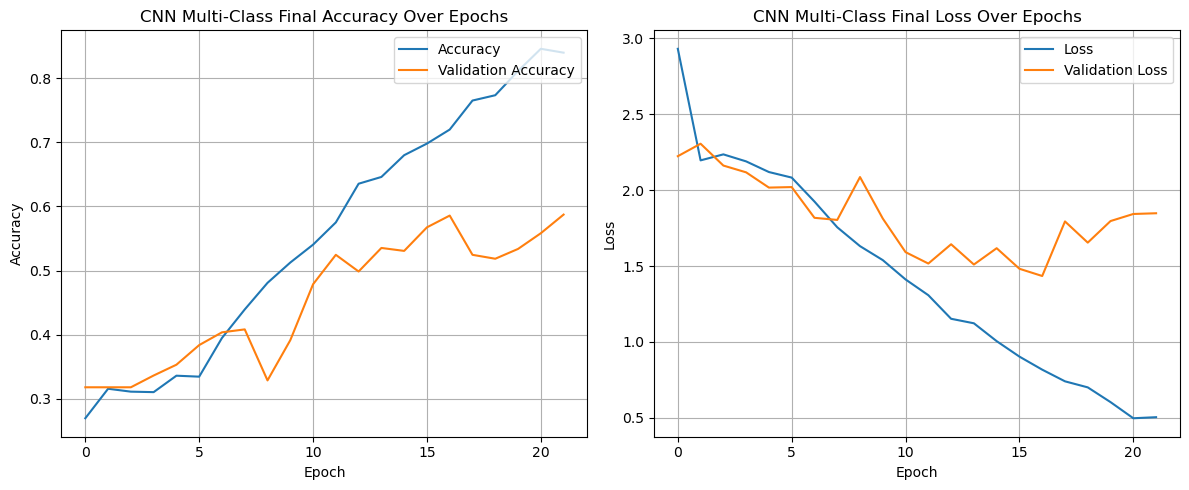

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
Confusion Matrix (Table Format):


amecro  amerob  bewwre  bkcchi  daejun  houfin  houspa  norfli  \
amecro      17       0       0       0       1       0       0       0   
amerob       0      36       4       1       1       0       8       0   
bewwre       0       0      21       0       2       3       5       0   
bkcchi       0       1       1       0       1       0       2       0   
daejun       0       0       8       0      25       0       2       0   
houfin       1       3       1       0       1       8      11       0   
houspa       1       3       4       0       4       0     189       0   
norfli       1       4       0       0       1       1       2       0   
rewbla       0      16       2       0       1       1      14       0   
sonspa       2      10      10       0       3       2       8       0   
spotow       2       3      10       0       0       0       5       0   
whcspa       0       1       0       0       3       0       2       0   

        rewbla  sonspa  spotow  whcspa  
amecro       2       1       1       0  
amerob       3       0       3       1  
bewwre       3      10       2       1  
bkcchi       2       3       1       4  
daejun       1       2       2       1  
houfin       0       2       1       0  
houspa       2       1       3       1  
norfli       0       1       2       0  
rewbla      15      11       2       0  
sonspa       3      41       5       3  
spotow       3       2      20       0  
whcspa       5       7       1      11

In [169]:
# Final hyperparameters
layers = 3
channels = 32
k_size = (7, 7)
pool = (4, 4)
dropout = 0.4
dense_layers = 1
units = 256
batch = 64
epoch = 100
title = "CNN Multi-Class Final"
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build and compile
model = build_multi_cnn_model(title, layers, channels, k_size, pool, 'relu', dropout, dense_layers, units)
model = seq_model_compile(title, model, 'rmsprop', 'categorical_crossentropy', 'accuracy')
history = cnn_model(title, model, X_train, X_test, y_train, y_test, epoch, batch, early_stop)

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm,
                     index=label_encoder.classes_,  
                     columns=label_encoder.classes_)  

print("Confusion Matrix (Table Format):")
display(cm_df)

In [173]:
results = []
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
results.append({
        'Title': title,
        'Layers': layers,
        'Channels': channels,
        'Kernel': k_size,
        'Pool': pool,
        'Dropout': drop,
        'Dense Layers': dense_layers,
        'Dense Units': units,
        'Batch Size': batch,
        'Epochs Trained': len(history.history['loss']),
        'Trainable Params': model.count_params(),
        'Accuracy': acc,
        'Macro F1': f1,
        'Macro Precision': precision,
        'Macro Recall': recall,
    })
results_df = pd.DataFrame(results)
display(results_df)

Title                                             Layers  \
0  CNN Multi-Class Final  <module 'tensorflow.keras.layers' from '/opt/a...   

   Channels  Kernel    Pool  Dropout  Dense Layers  Dense Units  Batch Size  \
0        32  (7, 7)  (4, 4)      0.4             1          256          64   

   Epochs Trained  Trainable Params  Accuracy  Macro F1  Macro Precision  \
0              22           1031180  0.585627   0.42703         0.437738   

   Macro Recall  
0      0.431629

In [175]:
model.save("cnn_bird_classifier.keras")

## Generate Spectograms for test files

In [178]:
# Path
test_dir = '/Users/markdaza/Library/CloudStorage/OneDrive-SeattleUniversity/DATA 5322/Homework3/test_birds'
test_files = ['test1.mp3', 'test2.mp3', 'test3.mp3']

# Array for spectrograms
test_specs = np.zeros((128, 517, len(test_files)))

# Generate spectrograms
for i, fname in enumerate(test_files):
    full_path = os.path.join(test_dir, fname)
    y, sr = librosa.load(full_path, duration=3)
    
    # Compute mel spectrogram
    spec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=128, win_length=512, n_mels=128)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    
    # Standardize w
    if spec_db.shape[1] < 517:
        pad_width = 517 - spec_db.shape[1]
        spec_db = np.pad(spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        spec_db = spec_db[:, :517]
    
    test_specs[:, :, i] = spec_db

print("All spectrograms processed. Shape:", test_specs.shape)

All spectrograms processed. Shape: (128, 517, 3)


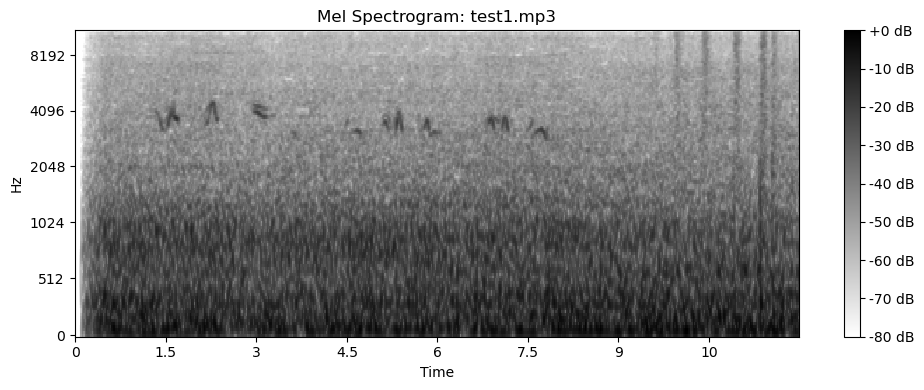

In [180]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(test_specs[:, :, 0], x_axis='time', y_axis='mel', sr=sr, cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram: test1.mp3")
plt.tight_layout()
plt.show()

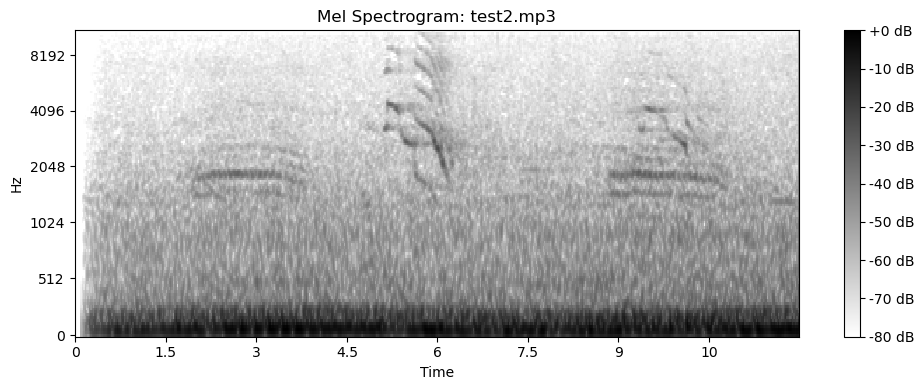

In [182]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(test_specs[:, :, 1], x_axis='time', y_axis='mel', sr=sr, cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram: test2.mp3")
plt.tight_layout()
plt.show()

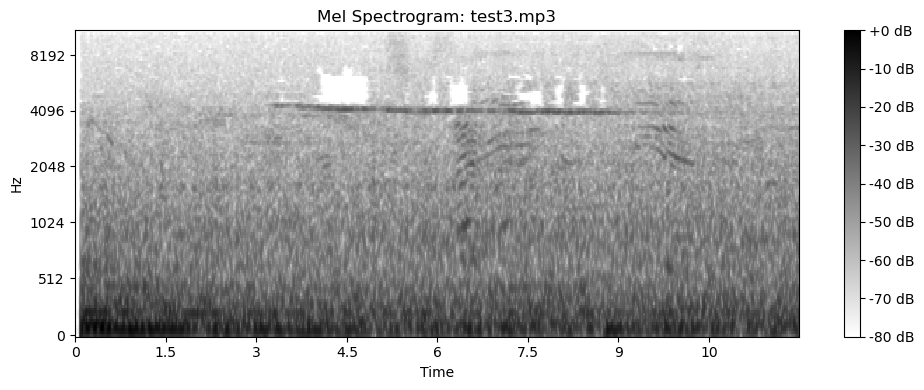

In [184]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(test_specs[:, :, 2], x_axis='time', y_axis='mel', sr=sr, cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram: test3.mp3")
plt.tight_layout()
plt.show()

In [194]:
# Extract mean and std from training set
mean = X_train.mean()
std = X_train.std()

# Apply Z-scaling to spectrograms
test_specs_scaled = (test_specs - mean) / std
test_specs_scaled = np.transpose(test_specs_scaled, (2, 0, 1)) 
test_specs_scaled = test_specs_scaled[..., np.newaxis]  

# Load Model
model_multi = load_model('cnn_bird_classifier.keras')

# Predict 
y_pred_probs = model_multi.predict(test_specs_scaled)  

# Get predictions for each spectrogram
top3_indices = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1] 
top3_probs = np.sort(y_pred_probs, axis=1)[:, -3:][:, ::-1]

# Decode labels of predictions to bird species
top3_labels = label_encoder.inverse_transform(top3_indices.flatten()).reshape(3, 3)

# Top predictions
for i, (labels, probs) in enumerate(zip(top3_labels, top3_probs)):
    print(f"\ntest{i+1}.mp3 - Top 3 Predictions:")
    for j in range(3):
        print(f"  {j+1}. {labels[j]} (prob: {probs[j]:.3f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

test1.mp3 - Top 3 Predictions:
  1. houspa (prob: 1.000)
  2. rewbla (prob: 0.000)
  3. whcspa (prob: 0.000)

test2.mp3 - Top 3 Predictions:
  1. houspa (prob: 0.904)
  2. spotow (prob: 0.096)
  3. rewbla (prob: 0.000)

test3.mp3 - Top 3 Predictions:
  1. houspa (prob: 1.000)
  2. spotow (prob: 0.000)
  3. whcspa (prob: 0.000)
